# PARKIN analysis notebook

Paper title: A mutational atlas for Parking proteostasis

Authors: Lene Clausen, Vasileios Voutsinos, Matteo Cagiada, Kristoffer E. Johansson, Martin Grønbæk-Thygesen, Snehal Nariya, Rachel L. Powell, Magnus K. N. Have, Vibe H. Oestergaard, Amelie Stein,Douglas M. Fowler, Kresten Lindorff-Larsen, Rasmus Hartmann-Petersen

Correspondence to: D.M.F. (dfowler@uw.edu), K.L.-L. (lindorff@bio.ku.dk), R.H.-P. (rhpetersen@bio.ku.dk)

Notebook by: Matteo Cagiada (matteo.cagiada@bio.ku.dk)


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
#import ptitprince as pt <---- uncomment if necessary
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.PDB import PDBParser
from Bio.PDB.HSExposure import HSExposureCB
import warnings
import mdtraj as md
from pylab import *
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.metrics import roc_curve, auc, r2_score
from scipy.stats import bootstrap

warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['legend.fontsize'] = 14

In [3]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_L_D_reordered={0:'R',1:'H',2:'K',3:'D',4:'E',5:'S',6:'T',7:'N',8:'Q',9:'C',10:'G',11:'P',12:'A',13:'V',14:'I',15:'L',16:'M',17:'F',18:'Y',19:'W'}
alphabetAA_D_D_reordered={14:0,6:1,8:2,2:3,3:4,15:5,16:6,11:7,13:8,1:9,5:10,12:11,0:12,17:13,7:14,9:15,10:16,4:17,19:18,18:19}

In [4]:
def spearman_output(x,y):
    return sp.stats.spearmanr(x,y)[0]

In [5]:
def heatmap_scores_reordered(ext_score,label_cm,WT_mask,lim_down,lim_up,color,x,WT_cmap='gnuplot_r',nan_cmap='Dark2_r',figs=[30,7],xtick_spacing=10):
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['axes.labelsize']  = 20

    score=np.copy(ext_score)

    for i in range(score.shape[1]):
        #print(i,score[:,i][0:10])
        score[:,alphabetAA_D_D_reordered[i]]=ext_score[:,i]
        #print(alphabetAA_D_D_reordered[i],score[:,alphabetAA_D_D_reordered[i]][0:10])

    score_nan=np.copy(ext_score)
    score_nan[:]=np.inf
    
    for i in range(score.shape[0]):
        for j in range(score.shape[1]):
                if np.isnan(ext_score[i,j])==True and WT_mask[i]!=alphabetAA_D_L[j+1]:
                    
                    score_nan[i,alphabetAA_D_D_reordered[j]]=1
                    #print(WT_mask[i],alphabetAA_D_D_reordered[alphabetAA_D_L[j+1]])
            
    fig, ax = plt.subplots(figsize=(figs[0],figs[1]))
    ylabels=[ alphabetAA_L_D_reordered[i] for i in range(0,20)]
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
 
    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=color,
                 vmin=lim_down,vmax=lim_up,interpolation='nearest')
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
    fig.colorbar(pos, label=label_cm)

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
    
    #ax.xaxis.set_ticks(np.arange(1, end, stepsize))

    plt.grid(axis='both',which='both',alpha=0.4)
    #plt.ylabel("mutation")
    plt.xlabel("Position")
    plt.ylim(-0.5,19.5)
    plt.xlim(x[0]-0.5,x[1]+0.5)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start+0.5, end, xtick_spacing))
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(axis='y',rotation=90)
    tmp=np.empty((len(WT_mask),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT_mask)):
        tmp[i,alphabetAA_D_D_reordered[alphabetAA_L_D[WT_mask[i]]-1]]=1
    
    print(score_nan[0,:])
    plt.imshow(score_nan.T, cmap=nan_cmap, aspect = 'auto',interpolation='nearest')
    plt.imshow(tmp.T, cmap=WT_cmap, aspect = 'auto',interpolation='nearest')
    

In [6]:
def heatmap_classes_reordered(ext_score,label_cm,WT_mask,lim_down,lim_up,color,x,WT_cmap='gnuplot_r',nan_cmap='Dark2_r',figs=[30,7],xtick_spacing=10):
    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    mpl.rcParams['axes.labelsize']  = 20

    score=np.copy(ext_score)

    for i in range(score.shape[1]):
        #print(i,score[:,i][0:10])
        score[:,alphabetAA_D_D_reordered[i]]=ext_score[:,i]
        #print(alphabetAA_D_D_reordered[i],score[:,alphabetAA_D_D_reordered[i]][0:10])

    score_nan=np.copy(ext_score)
    score_nan[:]=np.inf
    
    for i in range(score.shape[0]):
        for j in range(score.shape[1]):
                if np.isnan(ext_score[i,j])==True and WT_mask[i]!=alphabetAA_D_L[j+1]:
                    
                    score_nan[i,alphabetAA_D_D_reordered[j]]=1
                    #print(WT_mask[i],alphabetAA_D_D_reordered[alphabetAA_D_L[j+1]])
            
    fig, ax = plt.subplots(figsize=(figs[0],figs[1]))
    ylabels=[ alphabetAA_L_D_reordered[i] for i in range(0,20)]
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
 
    pos=ax.imshow(np.transpose(score), aspect = 'auto', cmap=mpl.colors.ListedColormap(["#d55c00", "#f0e442","#56b4e9", "#009e74","#5A5A5A"]),
                 vmin=lim_down,vmax=lim_up,interpolation='nearest')
    
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='gray')
    fig.colorbar(pos, label=label_cm)

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels)
    
    #ax.xaxis.set_ticks(np.arange(1, end, stepsize))

    plt.grid(axis='both',which='both',alpha=0.4)
    #plt.ylabel("mutation")
    plt.xlabel("Position")
    plt.ylim(-0.5,19.5)
    plt.xlim(x[0]-0.5,x[1]+0.5)
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start+0.5, end, xtick_spacing))
    ax.tick_params(axis='x',rotation=90)
    ax.tick_params(axis='y',rotation=90)
    tmp=np.empty((len(WT_mask),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT_mask)):
        tmp[i,alphabetAA_D_D_reordered[alphabetAA_L_D[WT_mask[i]]-1]]=1
    
    print(score_nan[0,:])
    plt.imshow(score_nan.T, cmap=nan_cmap, aspect = 'auto',interpolation='nearest')
    plt.imshow(tmp.T, cmap=WT_cmap, aspect = 'auto',interpolation='nearest')
    
    plt.show()

In [7]:
def correlation_plot(x,y,x_label='score1',y_label='score2',nan_value=-99999):
    
    def func(x, a, b):
        return a * x + b
    
    rng = np.random.default_rng()
    
    fig, ax = plt.subplots(1,1,figsize=(4,4))    
    
    bad = ~np.logical_or(np.isnan(x), np.isnan(y)) 
    
    x_t=np.compress(bad, x)
    y_t=np.compress(bad, y)

    xy= np.vstack([x_t,y_t])
    z = sp.stats.gaussian_kde(xy)(xy)
    
    idx = z.argsort()
    
    ax.grid(alpha=0.3)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    x_s, y_s, z = x_t[idx], y_t[idx], z[idx]
    ax.scatter(x_s, y_s, c=z, s=100,cmap='viridis')
        
    #stats

    
    print("spearman's r:", spearman_output(x_s,y_s))
    
    #correlation line

    
#     optimizedParameters, pcov = curve_fit(func, x_s, y_s);
    
#     ax.plot(x_s,func(x_s, *optimizedParameters),'r' ,label="fit" )
    
    ## bootstrap statistic
    
    res = bootstrap((x_s, y_s), spearman_output, vectorized=False, paired=True,
                random_state=rng)
    
    print("boostraping confidence interval:", res.confidence_interval)
    

In [8]:
def load_data_from_df(df,wt_seq,column_name,variant_col='variant',input_dict=None):
    
    mutation_load=df[variant_col].to_numpy()
    score_load=df[column_name].to_numpy()
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for idx, (v, s) in enumerate(zip(mutation_load,score_load)):
        if v[-1]=='=':
            mut_idx = alphabetAA_L_D[wt_seq[int(v[1:-1])-1]]-1
        else:
            mut_idx= alphabetAA_L_D[v[-1]]-1
        if isinstance(s, str):
            scores[int(v[1:-1])-1, mut_idx ]= input_dict[s]
        else:
            if not np.isnan(s):
                scores[int(v[1:-1])-1, mut_idx ]= s
                
    
                    
    return scores

In [9]:
#Custom color map
Wistia = mpl.cm.get_cmap('YlOrBr', 256)
newcolors = Wistia(np.linspace(0, 1, 256))
white = np.array([255/256, 255/256, 255/256, 1])
newcolors[:1, :] = white
newcmp = ListedColormap(newcolors)

In [10]:
#Custom color map
Wistia = mpl.cm.get_cmap('Blues', 256)
newcolors = Wistia(np.linspace(0, 1, 256))
white = np.array([255/256, 255/256, 255/256, 1])
newcolors[:1, :] = white
newcmp2 = ListedColormap(newcolors)

## Loading Datasets
### Load WT sequence

In [11]:
PARKIN_WT_sequence = "MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFAGKELRNDWTVQNCDLDQQSIVHIVQRPWRKGQEMNATGGDDPRNAAGGCEREPQSLTRVDLSSSVLPGDSVGLAVILHTDSRKDSPPAGSPAGRSIYNSFYVYCKGPCQRVQPGKLRVQCSTCRQATLTLTQGPSCWDDVLIPNRMSGECQSPHCPGTSAEFFFKCGAHPTSDKETSVALHLIATNSRNITCITCTDVRSPVLVFQCNSRHVICLDCFHLYCVTRLNDRQFVHDPQLGYSLPCVAGCPNSLIKELHHFRILGEEQYNRYQQYGAEECVLQMGGVLCPRPGCGAGLLPEPDQRKVTCEGGNGLGCGFAFCRECKEAYHEGECSAVFEASGTTTQAYRVDERAAEQARWEAASKETIKKTTKPCPRCHVPVEKNGGCMHMKCPQPQCRLEWCWNCGCEWNRVCMGDHWFDV"
PARKIN_5c23_sequence="MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFAGKELRNDWTVQNCDLDQQDIVHIVQRPWRKGQEMNAT------------------------------------------------------------NSFYVYCKGPCQRVQPGKLRVQCSTCRQATLTLTQGPSCWDDVLIPNRMSGECQSPHCPGTSAEFFFKCGAHPTSDKETSVALHLIATNSRNITCITCTDVRSPVLVFQCNSRHVICLDCFHLYCVTRLNDRQFVHDPQLGYSLPCVAGCPNSLIKELHHFRILGEEQYNRYQQYGAEECVLQMGGVLCPRPGCGAGLLPEPDQRKVTCEGNG-----FAFCRECKEAYHEGECSAVFE--------YRVDERAAEQARWEA--------TTKPCPRCHVPVEKNGGCMHMKCPQPQCRLEWCWNCGCEWNRVCMGDHWFDV"
PARKIN_6glb_sequence="MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFAGKELRNDWTVQNCDLDQQSIVHIVQR---------------------------QSLTRVDLS----------------------------------YNSFYVYCKGPCQRVQPGKLRVQCSTCRQATLTLTQGPSCWDDVLIPNRMSGECQSPHCPGTSAEFFFKCGAHPTSDKETSVALHLIATNSRNITCITCTDVRSPVLVFQCNSRHVICLDCFHLYCVTRLNDRQFVHDPQLGYSLPCVAGCPNSLIKELHHFRILGEEQYNRYQQYGAEECVLQMGGVLCPRPGCGAGLLPEPDCRKVTCE--NGLGCGFAFCRECKEAYHEGECS"
PARKIN_6glb_seq_long="MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFAGKELRNDWTVQNCDLDQQ-IVHIVQR---------------------------QSLTRVDLS----------------------------------YNSFYVYCKGPCQRVQPGKLRVQCSTCRQATLTLTQGPSCWDDVLIPNRMSGECQSPHCPGTSAEFFFKCGAHPTSDKETSVALHLIATNSRNITCITCTDVRSPVLVFQCNSRHVICLDCFHLYCVTRLNDRQFVHDPQLGYSLPCVAGCPNSLIKELHHFRILGEEQYNRYQQYGAEECVLQMGGVLCPRPGCGAGLLPEPDCRKVTCE--NGLGCGFAFCRECKEAYHEGECS---------------------------------------------------------------------------------------"



### Load Datframe

In [12]:
PRKN_df_data=pd.read_excel('./SupplementalFile1_revised03.xlsx',sheet_name=0,index_col=0)

In [13]:
PRKN_df_data

,variant,abundance_score,abundance_score_std,gemme_de,normalized_rosetta_ddg,wcn_sidechains,degrons,QCDPred,QCDPred_mut - QCDPred_wt,AF_confidence,Clinvar,gnomAD_allele_frequency,FunctionalModel_residue_predictions,EVE,rASA
0,M1A,NaN,NaN,-0.790780,2.290115,11.609006,1.089541,NaN,NaN,86.60,NaN,NaN,WT-like,NaN,0.281250
1,M1C,NaN,NaN,-1.224936,2.264598,11.609006,1.089541,NaN,NaN,86.60,NaN,NaN,WT-like,NaN,0.281250
2,M1D,NaN,NaN,-1.258947,2.675402,11.609006,1.089541,NaN,NaN,86.60,NaN,NaN,WT-like,NaN,0.281250
3,M1E,NaN,NaN,-0.680452,3.324253,11.609006,1.089541,NaN,NaN,86.60,NaN,NaN,WT-like,NaN,0.281250
4,M1F,NaN,NaN,-0.454427,3.378966,11.609006,1.089541,NaN,NaN,86.60,NaN,NaN,WT-like,NaN,0.281250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9295,V465S,0.763978,0.048405,-2.467052,0.506437,15.736868,1.730353,NaN,NaN,76.01,NaN,NaN,WT-like,NaN,0.316092
9296,V465T,0.201423,0.090136,-2.467052,1.099655,15.736868,1.730353,NaN,NaN,76.01,NaN,NaN,WT-like,NaN,0.316092
9297,V465=,NaN,NaN,NaN,NaN,15.736868,1.730353,NaN,NaN,76.01,NaN,NaN,WT-like,NaN,0.316092
9298,V465W,1.353358,0.036910,-2.467052,0.532644,15.736868,1.730353,NaN,NaN,76.01,NaN,NaN,WT-like,NaN,0.316092


### Load MAVE data

In [14]:
PARKIN_scores=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='abundance_score')
PARKIN_scores_err=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='abundance_score_std')

In [15]:
PARKIN_scores_med=np.nanmedian(PARKIN_scores,axis=1)

In [16]:
PARKIN_scores_std=np.nanstd(PARKIN_scores,axis=1)

### load single replicates exp

In [17]:
PRKN_single_replicates=pd.read_excel('./SupplementalFile1.xlsx',sheet_name=2)

### Load computational data
- Rosetta Scores PARKIN

In [18]:
normalized_rosetta_PARKIN_AF=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='normalized_rosetta_ddg')

In [19]:
normalized_rosetta_PARKIN_AF_avg=np.nanmedian(normalized_rosetta_PARKIN_AF,axis=1)

- GEMME score

In [20]:
GEMME_PARKIN_scores=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='gemme_de')

In [21]:
GEMME_PARKIN_scores_med=np.nanmedian(GEMME_PARKIN_scores,axis=1)

- EVE score

In [22]:
EVE_PARKIN_scores=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='EVE')

In [23]:
EVE_PARKIN_scores_med=np.nanmedian(EVE_PARKIN_scores,axis=1)

- confidence score

In [24]:
PARKIN_confidence_score=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='AF_confidence')
PARKIN_confidence_score=np.nanmedian(PARKIN_confidence_score,axis=1)

### wcn 

In [25]:
PARKIN_wcn=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='wcn_sidechains')
PARKIN_wcn=np.nanmedian(PARKIN_wcn,axis=1)

In [26]:
PARKIN_wcn_tile=[]
for i in range((len(PARKIN_WT_sequence)//12)):
    if i<35:
        PARKIN_wcn_tile.append(np.median(PARKIN_wcn[0+i*12:24+i*12]))
    else:
        PARKIN_wcn_tile.append(np.median(PARKIN_wcn[0+i*12:]))


In [27]:
PARKIN_rASA=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='rASA')
PARKIN_rASA=np.nanmedian(PARKIN_rASA,axis=1)

### gnomad and clinvar

In [28]:
gnomad_PARKIN_freq_db_matrix=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='gnomAD_allele_frequency')

In [29]:
dict_clinvar={'benign':0,'pathogenic':1}

In [30]:
clinvar_PARKIN_db_matrix=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='Clinvar',input_dict=dict_clinvar)

### degron exp

In [31]:
temp=pd.read_excel('./SupplementalFile1.xlsx',sheet_name=1)
PARKIN_degron_tiles=[]
med_pos=np.arange(11,465,12)

for i,(m,s,d) in enumerate(zip(med_pos,temp['tsi'].to_numpy(),temp['tsi_sd'].to_numpy())):    
    PARKIN_degron_tiles.append([m,s,float(d)])

PARKIN_degron_tiles=np.array(PARKIN_degron_tiles)



In [32]:
PARKIN_degron_residues=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='degrons')

#### single variant degron

In [33]:
PARKIN_degron_tile_9_10_single=pd.DataFrame([[10,'L123A',1.22,0.030,0.2],[10,'I122D',1.336,0.006,0.10],[10,'A120I',0.2,0.007,0.42],[10,'G118I',0.172,0.007,0.56],[10,'wt10',1.,0.,0.25],
                                             [10,'G118W',0.114,0.002,0.25],[10,'G118L',0.24,0.,0.25],[10,'H124M',0.68,0.06,1],[10,'L119R',1.13,0.06,0.25],[10,'V117S',0.92,0.05,0.25],
                                             [9,'S109I',0.504,0.,0.44],[9,'D106I',0.48,0.007,0.6],[9,'wt9',0.996,0.,0.30],[9,'S109F',0.55,0.02,0.30],[9,'S108Y',0.75,0.02,0.30]],
                                            columns=['tile','mutation','score','error','pred'])

In [34]:
temp=[]
temp_error=[]
for i in PARKIN_degron_tile_9_10_single['mutation']:
    if i !='wt9' and i !='wt10':
        temp.append(PARKIN_scores[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1])
        temp_error.append(PARKIN_scores_err[int(i[1:-1])-1,alphabetAA_L_D[i[-1]]-1])
    else:
        temp.append(1.0)
        temp_error.append(0)

In [35]:
PARKIN_degron_tile_9_10_single['vamp']=temp
PARKIN_degron_tile_9_10_single['vamp_error']=temp_error

### load degron pred by QCD

In [36]:
PARKIN_pred_degron=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='QCDPred')
PARKIN_pred_degron=np.nanmedian(PARKIN_pred_degron,axis=-1)

### load FM prediction

In [37]:
dict_fm_classes_to_number={'WT-like':0,'Functional site':1, 'Not assgined':5,'Total-loss':2}
FM_prediction_residues=load_data_from_df(PRKN_df_data,PARKIN_WT_sequence,column_name='FunctionalModel_residue_predictions',input_dict=dict_fm_classes_to_number)
FM_prediction_residues=np.nanmedian(FM_prediction_residues,axis=1)

In [38]:
count=[0,0,0,0,0,0]
for i,n in enumerate(PARKIN_scores_med):
    if n<=0.5:
        count[int(FM_prediction_residues[i])]+=1
print(count/np.sum(count))

[0.104 0.24  0.608 0.    0.    0.048]


In [39]:
count=[0,0,0,0,0,0]
for i,n in enumerate(FM_prediction_residues):
    count[int(n)]+=1
print(count/np.sum(count))

[0.60860215 0.14408602 0.21290323 0.         0.         0.0344086 ]


### dataframe clinical variants

In [40]:
mutation_disease=[]
extract_disease=[]
extract_mave=[]
extract_gemme=[]
extract_ddg=[]
extract_gnomad=[]
extract_afidr=[]
extract_FM=[]
extract_wcn=[]
extract_QCDPred=[]
extract_degrons=[]
extract_EVE=[]
extract_rASA=[]
for i in range(clinvar_PARKIN_db_matrix.shape[0]):
    for j in range(clinvar_PARKIN_db_matrix.shape[1]):
        if np.isnan(clinvar_PARKIN_db_matrix[i,j]):
            pass
        else:
            mutation_disease.append(PARKIN_WT_sequence[i]+str(i+1)+alphabetAA_D_L[j+1])
            if  clinvar_PARKIN_db_matrix[i,j]==1:
                extract_disease.append('pathogenic')                
            elif clinvar_PARKIN_db_matrix[i,j] == 0:
                extract_disease.append('benign')                
            if np.isnan(gnomad_PARKIN_freq_db_matrix[i,j]):
                extract_gnomad.append(np.inf)
            else:
                extract_gnomad.append(gnomad_PARKIN_freq_db_matrix[i,j])
            extract_mave.append(PARKIN_scores[i,j])
            extract_gemme.append(GEMME_PARKIN_scores[i,j])
            extract_EVE.append(EVE_PARKIN_scores[i,j])
            extract_ddg.append(normalized_rosetta_PARKIN_AF[i,j])
            extract_afidr.append(PARKIN_confidence_score[i])
            extract_FM.append(FM_prediction_residues[i])
            extract_wcn.append(PARKIN_wcn[i])
            extract_rASA.append(PARKIN_rASA[i])
            extract_QCDPred.append(PARKIN_pred_degron[i])
            extract_degrons.append(PARKIN_degron_residues[i])

In [41]:
df_disease= pd.DataFrame({'mutation': mutation_disease,
                          'disease':extract_disease,
                          'mave':extract_mave,
                          'gemme': extract_gemme,
                          'EVE': extract_EVE,
                          'ddg_AF':extract_ddg,
                          'wcn':extract_wcn,
                          'rASA':extract_rASA,
                          'TSI':extract_degrons,
                          'QCDPred':extract_QCDPred,
                          'freq_gnomad':extract_gnomad,
                          'AF_confidence':extract_afidr,
                          'FunctionalModel_residue_class':extract_FM
                         })

## Analysis

### Experimental heatmaps

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf inf inf  1.
  1.  1.]


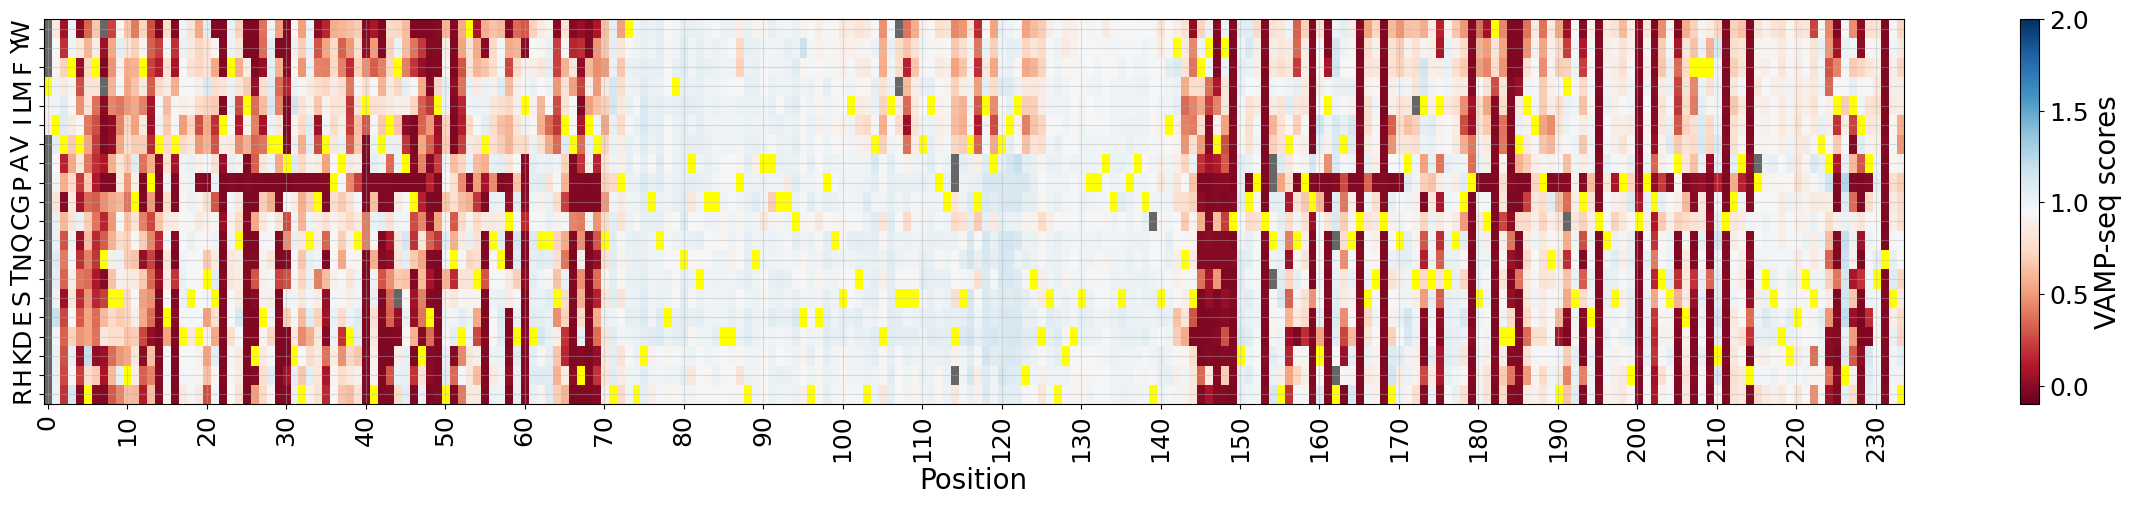

In [42]:
heatmap_scores_reordered(PARKIN_scores,'VAMP-seq scores',PARKIN_WT_sequence,2,0,'RdBu',[0,233],figs=[30,5])
plt.savefig('./figures/PARKIN_heatmap_MAVE_1_reordered.pdf',dpi=300, facecolor='w')

In [43]:
counts=[0,0,0]
for score in PARKIN_scores.flatten():
    if not np.isnan(score):
        if score <0.5:
            counts[1]+=1
            if score <0.25:
                    counts[0]+=1
        else:
            counts[2]+=1

In [44]:
print(counts)
print(counts/np.sum(counts))

[1846, 2431, 6325]
[0.17411809 0.22929636 0.59658555]


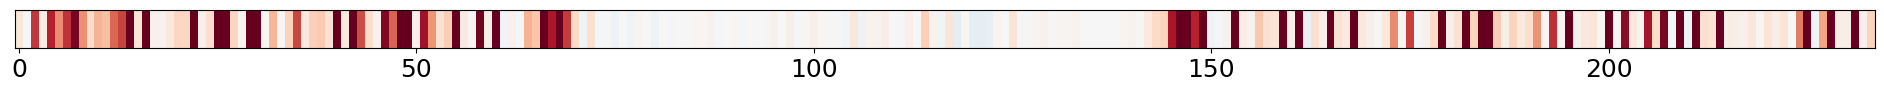

In [45]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(PARKIN_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,233.5)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/PARKIN_comp_mode_comparison.pdf')
#plt.tight_layout()
plt.savefig('./figures/PARKIN_heamap_MAVE_med_1.pdf',dpi=300, facecolor='w')

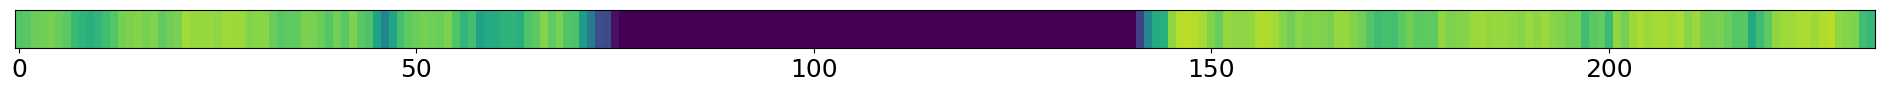

In [46]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(PARKIN_confidence_score.reshape(1,-1),aspect= 'auto',cmap='viridis',vmin=50,vmax=100,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,233.5)
#plt.grid(axis='x',which='both',color='gray', linestyle='-')
#plt.savefig('./Figures/PARKIN_comp_mode_comparison.pdf')
#plt.tight_layout()
plt.savefig('./figures/PARKIN_heamap_pLDDT_AF_1.pdf',dpi=300, facecolor='w')

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf inf inf  1.
  1.  1.]


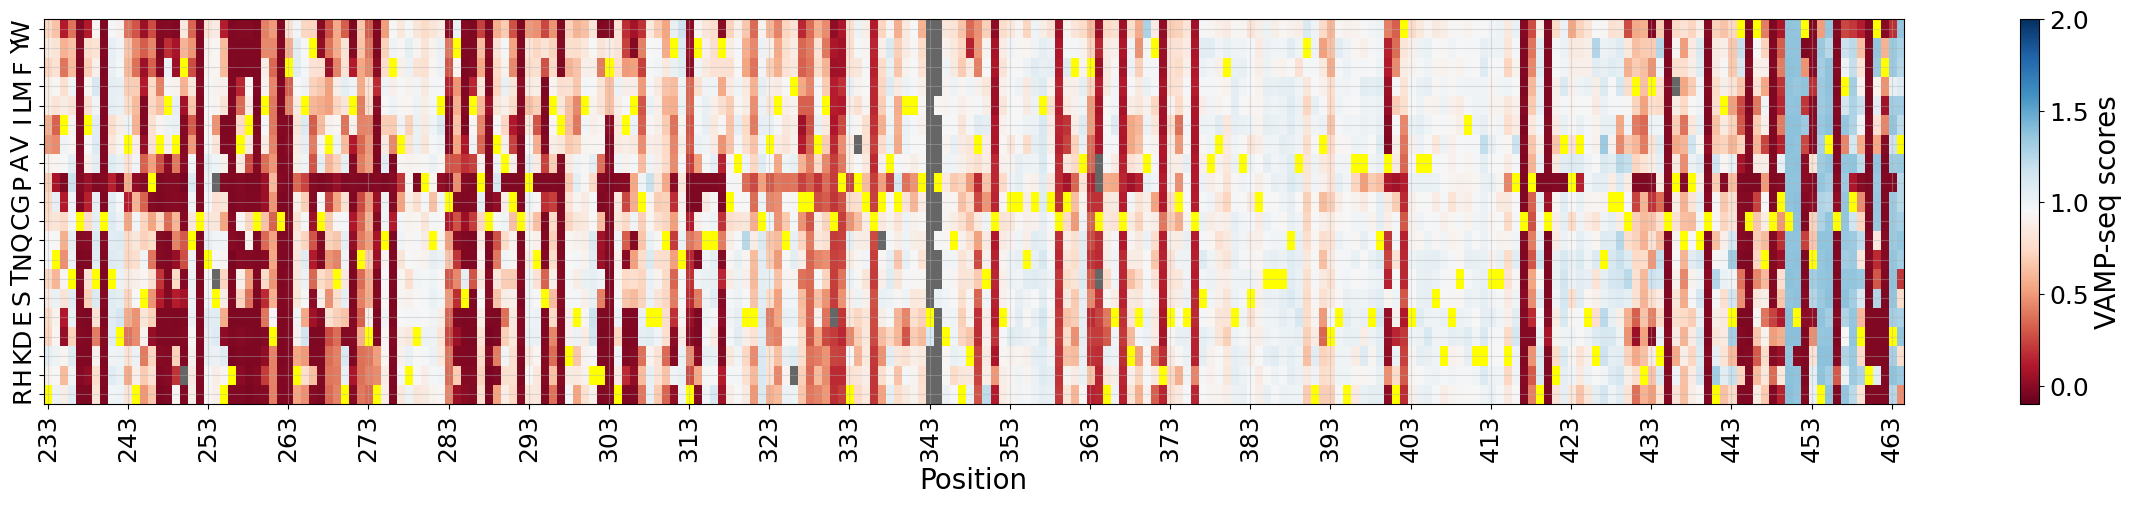

In [47]:
heatmap_scores_reordered(PARKIN_scores,'VAMP-seq scores',PARKIN_WT_sequence,2,0,'RdBu',[233,len(PARKIN_WT_sequence)-1],figs=[30,5])
#plt.savefig('./figures/PARKIN_heatmap_MAVE_2_reordered.pdf',dpi=300, facecolor='w')

(232.5, 464.5)

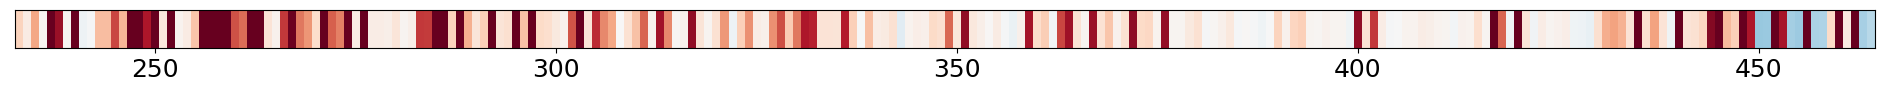

In [48]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(PARKIN_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(233-0.5,len(PARKIN_WT_sequence)+.5-1)

#plt.savefig('./figures/PARKIN_heamap_MAVE_med_2.pdf',dpi=300, facecolor='w')

(232.5, 464.5)

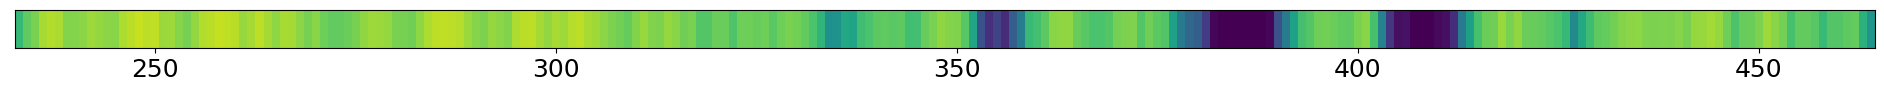

In [49]:
fig, (ax1) = plt.subplots(1,1,figsize=(24,0.5))

ax1.imshow(PARKIN_confidence_score.reshape(1,-1),aspect= 'auto',cmap='viridis',vmin=50,vmax=100,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(233-0.5,len(PARKIN_WT_sequence)+.5-1)

#plt.savefig('./figures/PARKIN_heamap_pLDDT_AF_2.pdf',dpi=300, facecolor='w')#

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. inf inf inf  1.
  1.  1.]


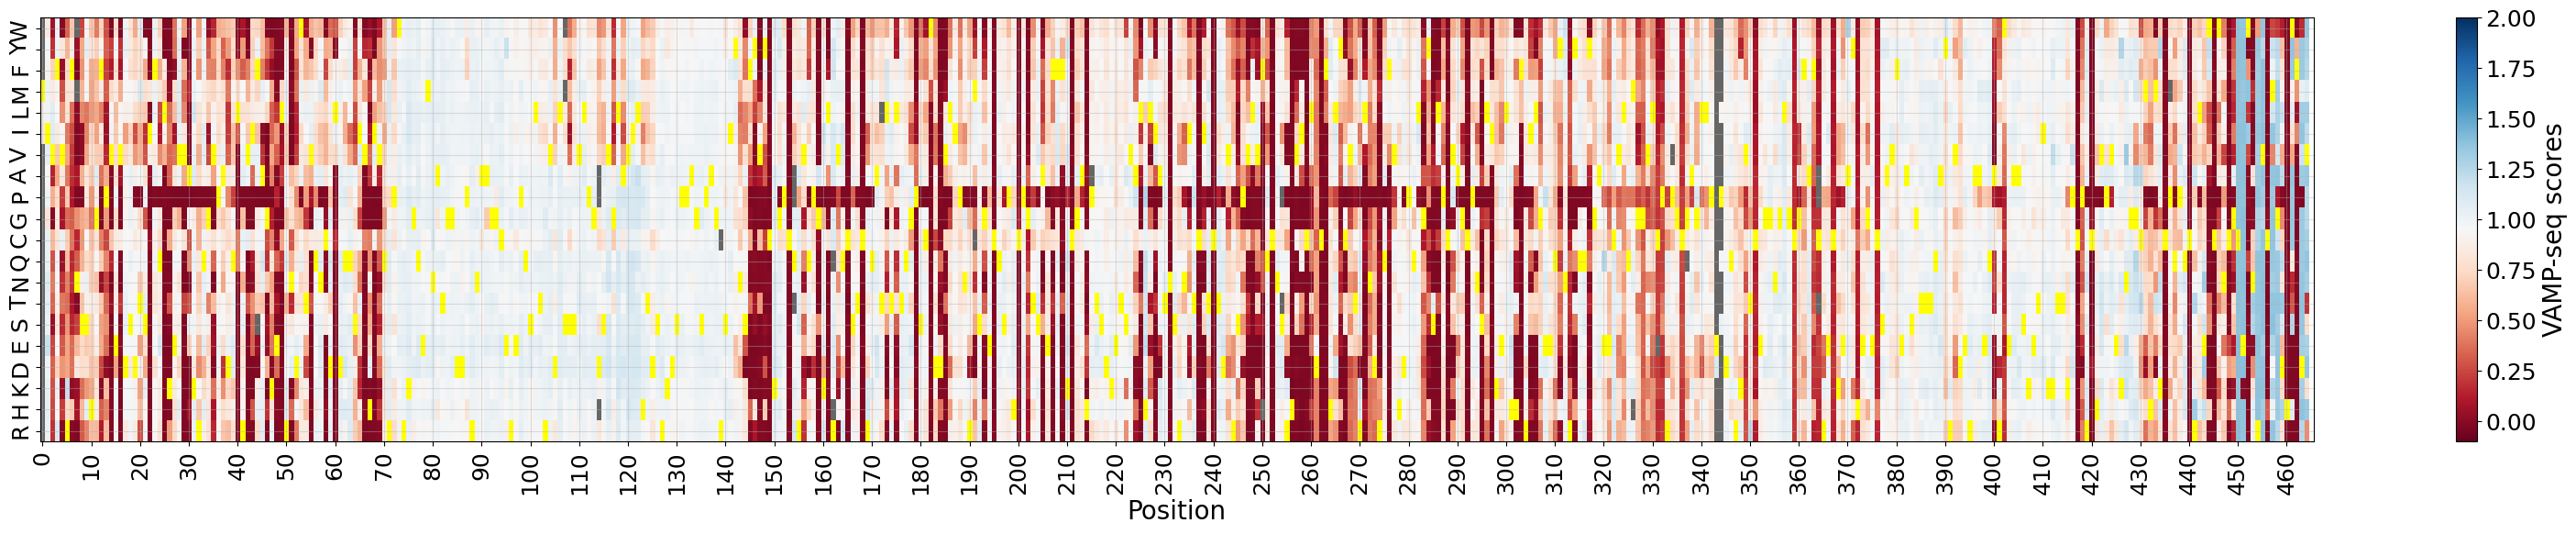

In [50]:
heatmap_scores_reordered(PARKIN_scores,'VAMP-seq scores',PARKIN_WT_sequence,2,0,'RdBu',[0,len(PARKIN_WT_sequence)],figs=[40,6])
#plt.savefig('./figures/PARKIN_heatmap_MAVE_all_reordered.pdf',dpi=300, facecolor='w')

### Computational protocols heatmaps
- GEMME scores

[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf]


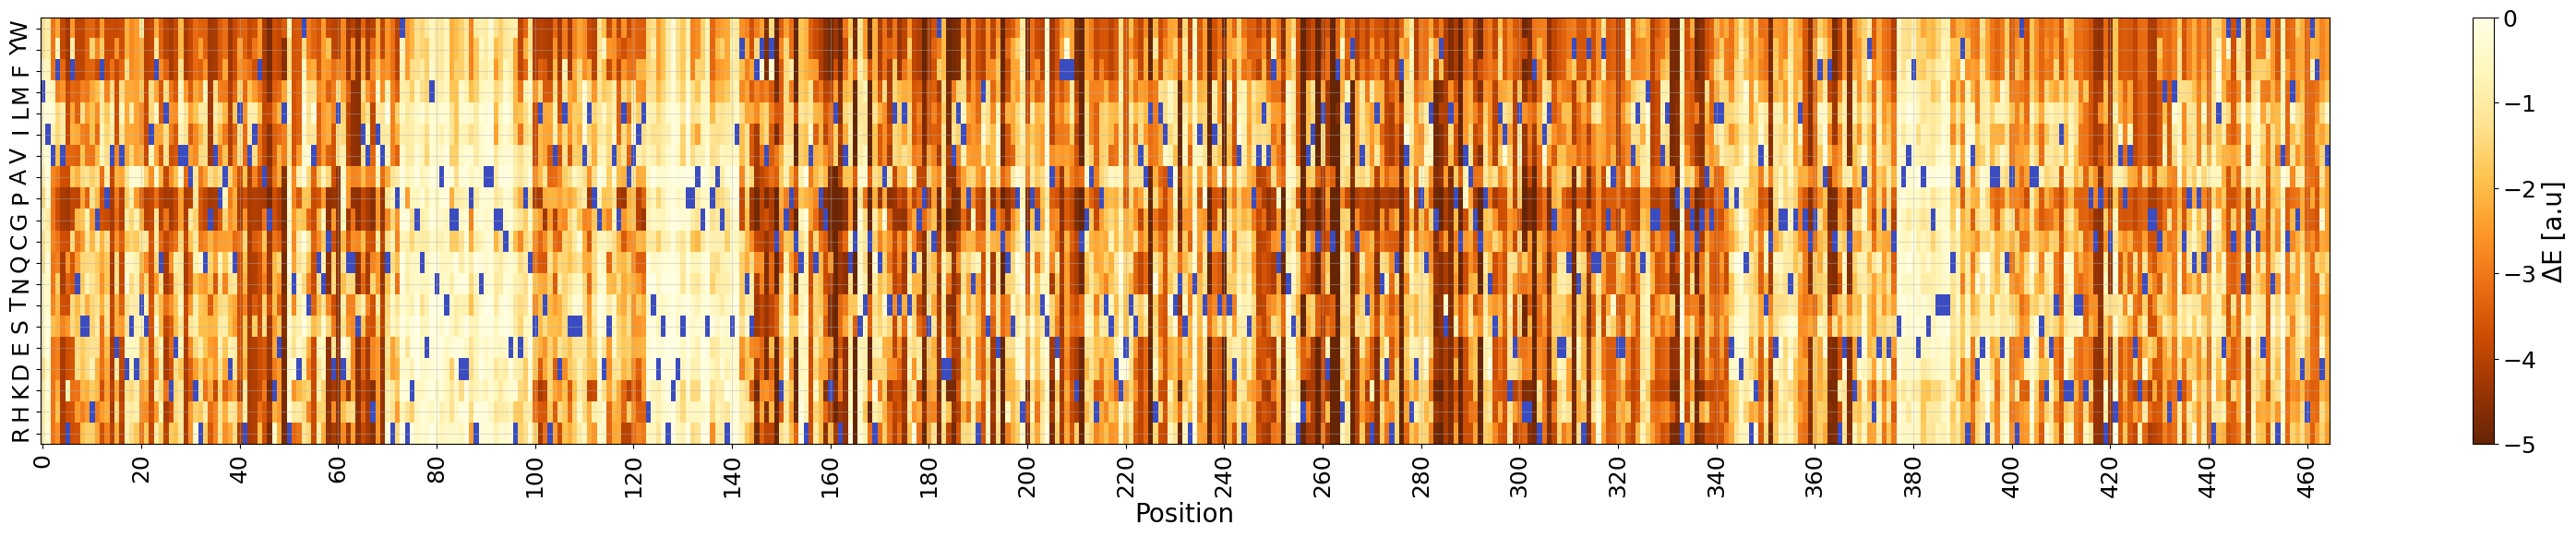

In [51]:
heatmap_scores_reordered(GEMME_PARKIN_scores,'\u0394E [a.u]',PARKIN_WT_sequence,-5,0,'YlOrBr_r',[0,len(PARKIN_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[40,6])
#plt.savefig('./figures/PARKIN_heatmap_GEMME.pdf',dpi=300, facecolor='w')

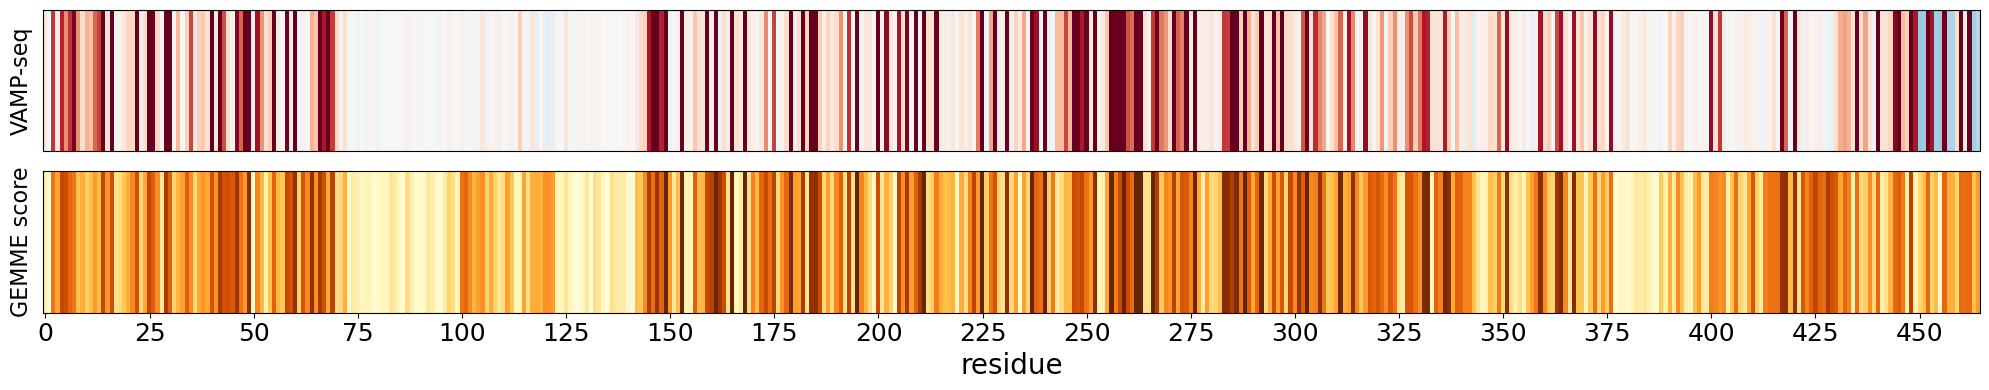

In [52]:
# Comparison with experimental MAVE residue colour classification
fig, ((ax1),(ax2)) = plt.subplots(2,1,figsize=(20,4))

ax1.imshow(PARKIN_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_ylabel('VAMP-seq',fontsize=16)
ax1.set_xticks([])

ax2.imshow(GEMME_PARKIN_scores_med.reshape(1,-1),aspect= 'auto',cmap='YlOrBr_r',vmin=-5,vmax=0,interpolation='nearest')
ax2.set_yticks([])

ax2.set_xlabel('residue')
ax2.set_ylabel('GEMME score',fontsize=16)
ax2.xaxis.set_ticks(np.arange(0, len(PARKIN_WT_sequence), 25))

plt.tight_layout()
#plt.savefig('./figures/PARKIN_heatmap_coevo_res.pdf',dpi=300, facecolor='w')

- Rosetta ddg

[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf]


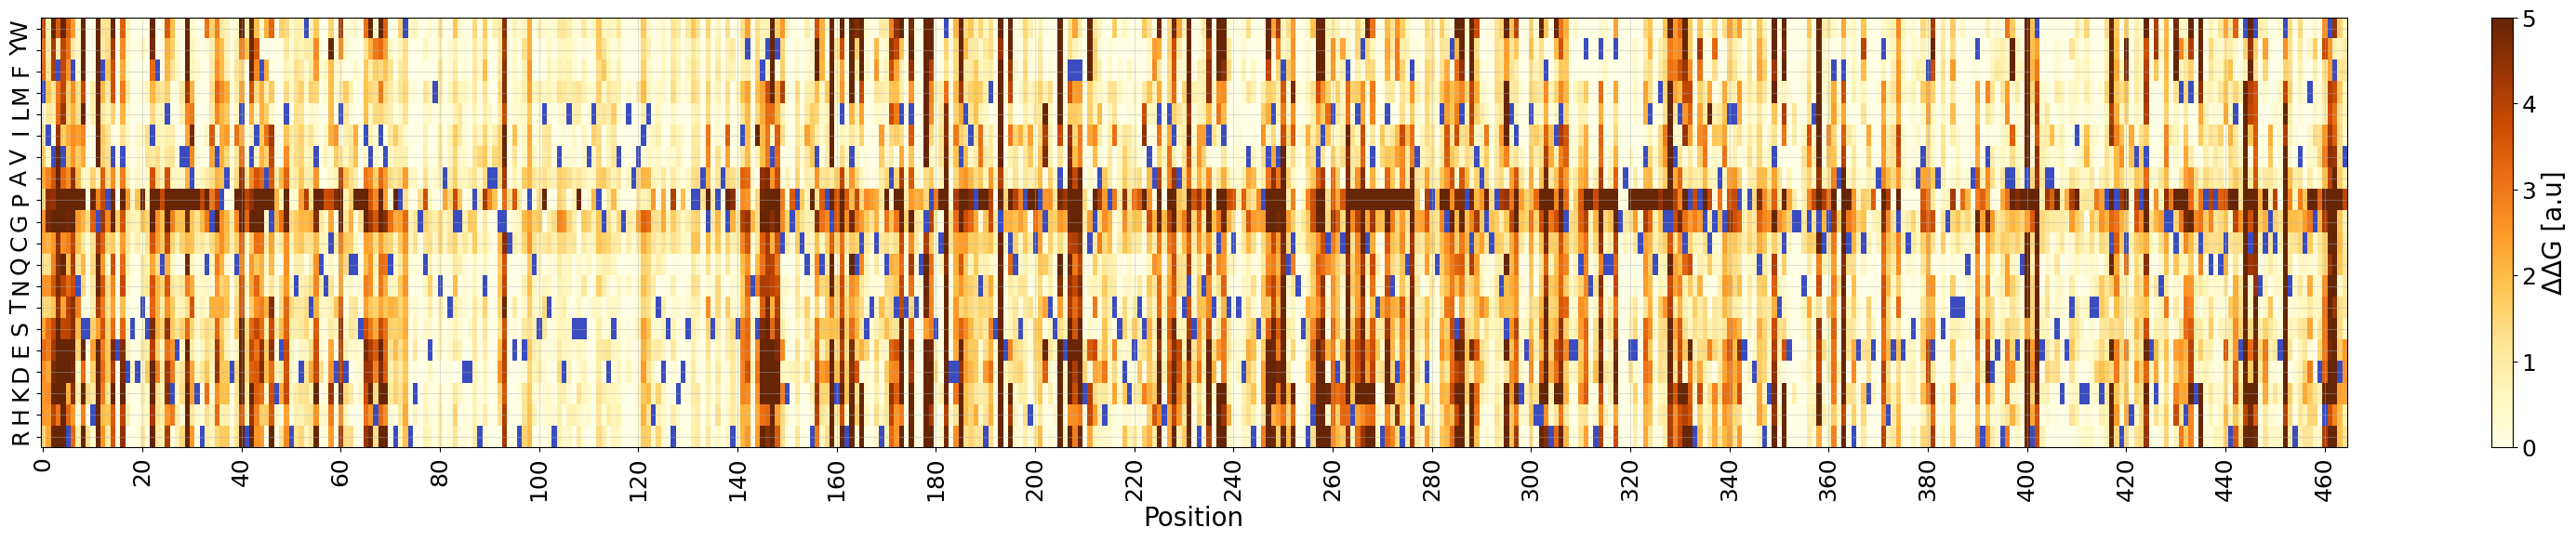

In [53]:
heatmap_scores_reordered(normalized_rosetta_PARKIN_AF,'\u0394\u0394G [a.u]',PARKIN_WT_sequence,0,5,'YlOrBr',[0,len(PARKIN_WT_sequence)-1],WT_cmap='coolwarm',xtick_spacing=20,figs=[40,6])
#plt.savefig('./figures/PARKIN_heatmap_ddg_AF.pdf',dpi=300, facecolor='w')

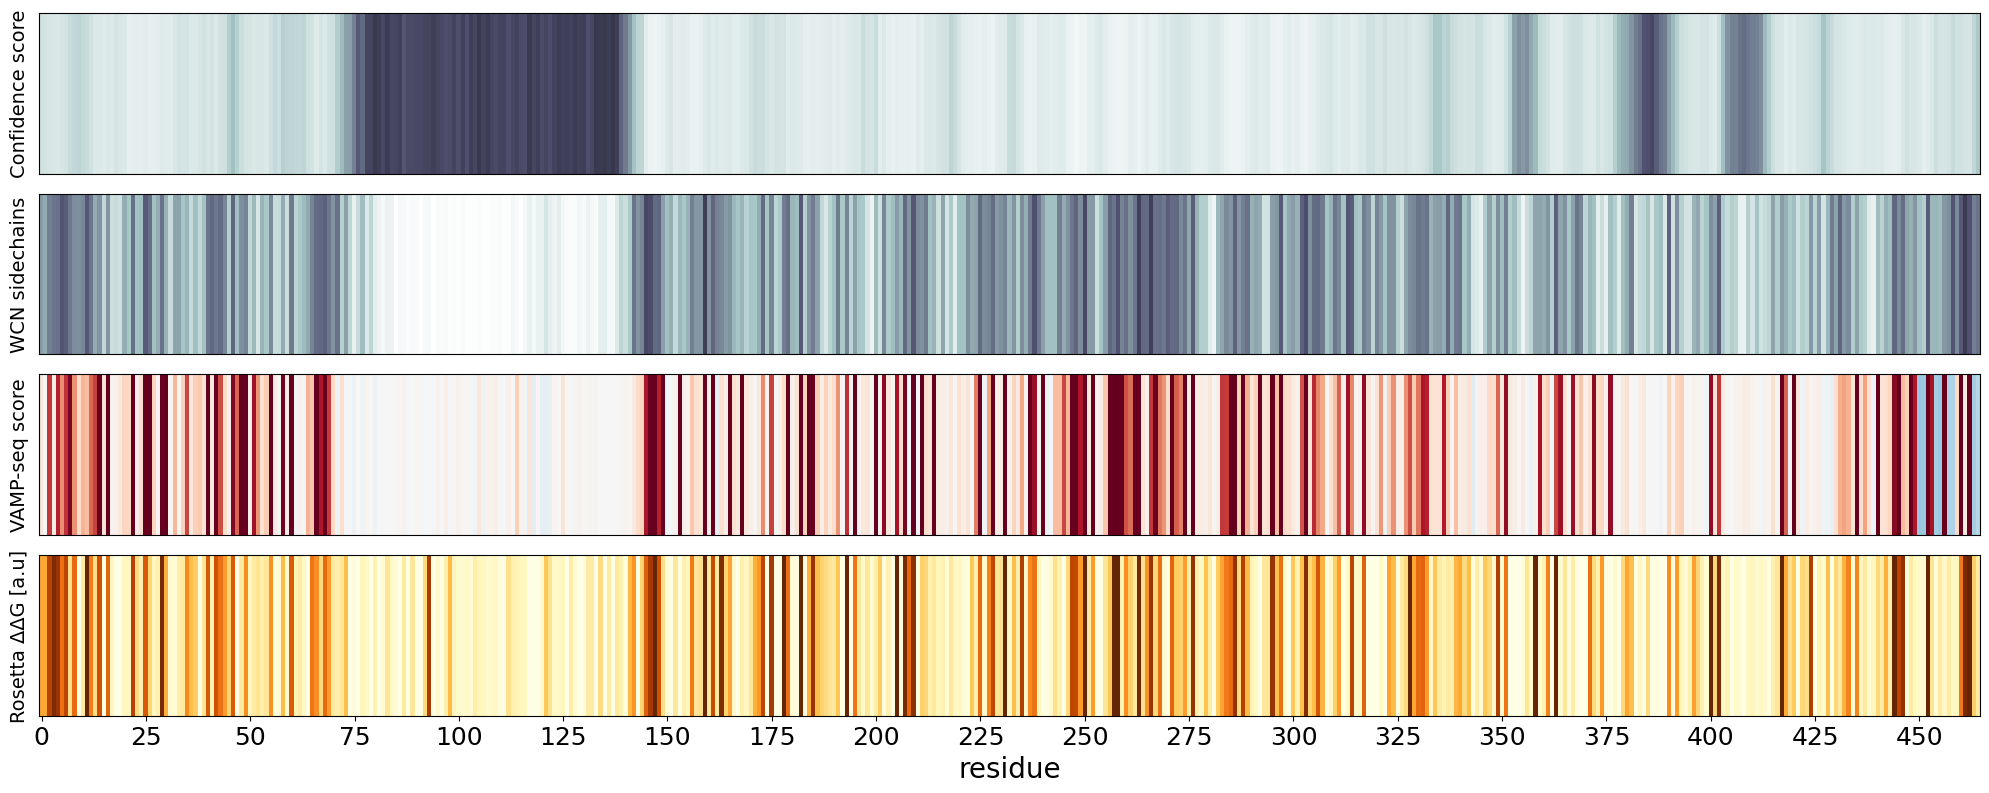

In [54]:
# Comparison with experimental MAVE residue colour classification
fig, ((ax0),(ax1),(ax2),(ax3)) = plt.subplots(4,1,figsize=(20,8))

ax0.imshow(PARKIN_confidence_score.reshape(1,-1),aspect= 'auto',cmap='bone',vmin=0,vmax=100,interpolation='nearest')
ax0.set_yticks([])
ax0.set_ylabel('Confidence score',fontsize=14)
ax0.set_xticks([])

ax1.imshow(PARKIN_wcn.reshape(1,-1),aspect= 'auto',cmap='bone_r',vmin=0,vmax=30,interpolation='nearest')
ax1.set_yticks([])
ax1.set_ylabel('WCN sidechains',fontsize=14)
ax1.set_xticks([])


ax2.imshow(PARKIN_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax2.set_yticks([])
ax2.set_ylabel('VAMP-seq score',fontsize=14)
ax2.set_xticks([])

#ax1.set_xlabel('residue')
ax3.imshow(normalized_rosetta_PARKIN_AF_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=5,interpolation='nearest')
ax3.set_yticks([])

ax3.set_xlabel('residue')
ax3.set_ylabel('Rosetta \u0394\u0394G [a.u]',fontsize=14)
ax3.xaxis.set_ticks(np.arange(0, len(PARKIN_WT_sequence), 25))

plt.tight_layout()
#plt.savefig('./figures/PARKIN_heatmap_rosetta_res.pdf',dpi=300, facecolor='w')

### Single replicates comparison

In [55]:
label_single=[]
data_single=np.empty((len(PRKN_single_replicates['Variants'][1:]),4),dtype=float)
for i,n in enumerate(PRKN_single_replicates['Variants'][1:]):
    label_single.append(n)
    if n=='WT' or n[-1]=='x':
        pass
    else:
        data_single[i]=np.array([PRKN_single_replicates['mean'][i+1],PRKN_single_replicates['sd'][i+1],PARKIN_scores[int(n[1:-1])-1,alphabetAA_L_D[n[-1]]-1],PARKIN_scores_err[int(n[1:-1])-1,alphabetAA_L_D[n[-1]]-1]])
        

In [56]:
data_single[:,0]

array([9.24655087e-001, 1.66815718e+000, 1.01050751e+000, 4.77761480e-321,
       1.10822863e+000, 1.42808574e-001, 6.96082779e-001, 1.11635871e+000,
       9.61320522e-001, 2.45550626e-321])

Text(0, 0.5, 'GFP-mCherry triplicate mean normalized')

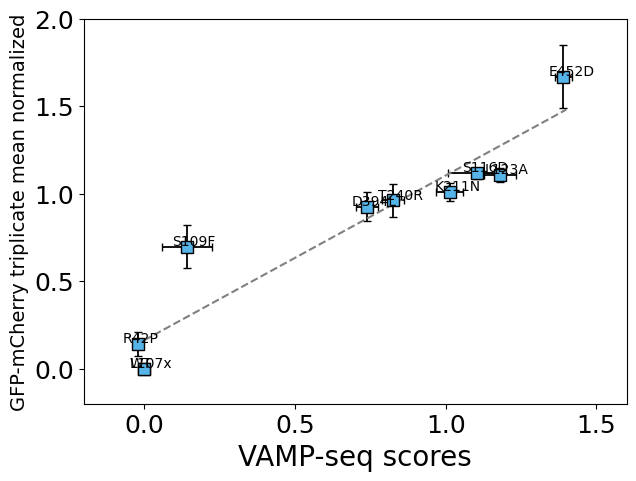

In [57]:
fig, ax = plt.subplots(figsize=(7,5))

ax.errorbar(data_single[:,2],data_single[:,0],xerr=data_single[:,3],yerr=data_single[:,1],fmt='s',
            elinewidth=1.3,ms=8,capsize=3,capthick=1,c='k',mec='k',mfc='#56b4e9')

for i, label in enumerate(label_single):
    ax.annotate(label, (data_single[:,2][i]-0.05, data_single[:,0][i]+0.01))
    
p,n=np.polyfit(data_single[:,2],data_single[:,0], 1)

ax.plot([0,1.4],[p*0+n,p*1.4+n],'--',c='gray')
ax.set_xlim(-0.2,1.6)
ax.set_ylim(-0.2,2)

ax.set_xlabel('VAMP-seq scores')
ax.set_ylabel('GFP-mCherry triplicate mean normalized',fontsize=14)

#plt.savefig('./figures/PRKN_single_replicas.pdf')

In [58]:
sp.stats.spearmanr(data_single[:,2],data_single[:,0])

SpearmanrResult(correlation=0.9515151515151514, pvalue=2.279854920641689e-05)

### TM /Ligase data

In [59]:
data_excel_file=pd.read_excel('./SupplementalFile1_revised03.xlsx',sheet_name=4)

In [60]:
tm_avg=np.mean(data_excel_file[['temp1(C)','temp2(C)','temp2(C)']].to_numpy(),axis=-1)

In [61]:
tm_std=np.std(data_excel_file[['temp1(C)','temp2(C)','temp2(C)']].to_numpy(),axis=-1)

0.11790272563280511 -5.8370111736892065
-0.6939757081633432 1.0556653167863503
1 0.5923961026580911
1 -0.4787114845938376


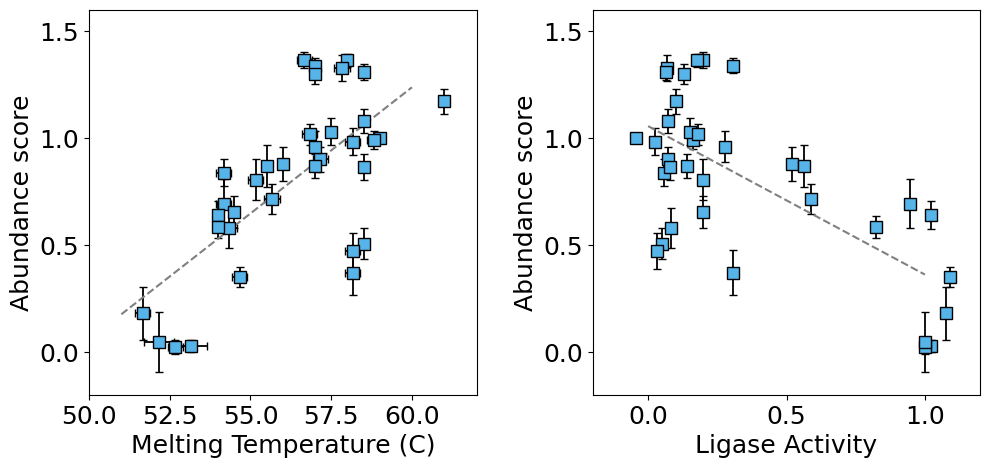

In [62]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11.5,5),)

ax1.errorbar(tm_avg,data_excel_file['VAMP_score'].to_numpy(),xerr=tm_std,yerr=data_excel_file['VAMP_score std'],fmt='s',
            elinewidth=1.3,ms=8,capsize=3,capthick=1,c='k',mec='k',mfc='#56b4e9')

ax1.set_xlim(50,62)
ax1.set_ylim(-0.2,1.6)

ax1.set_xlabel('Melting Temperature (C)',fontsize=18)
ax1.set_ylabel('Abundance score',fontsize=18)

p,n=np.polyfit(tm_avg,data_excel_file['VAMP_score'].to_numpy(), 1)
print(p,n)

ax1.plot([51,60],[p*51+n,p*60+n],'--',c='gray')

ax2.errorbar(data_excel_file['Ratio UbcH7 lost'].to_numpy(),data_excel_file['VAMP_score'].to_numpy(),yerr=data_excel_file['VAMP_score std'],fmt='s',
            elinewidth=1.3,ms=8,capsize=3,capthick=1,c='k',mec='k',mfc='#56b4e9')

ax2.set_xlim(-0.2,1.2)
ax2.set_ylim(-0.2,1.6)

ax2.set_xlabel('Ligase Activity',fontsize=18)
ax2.set_ylabel('Abundance score',fontsize=18)

plt.subplots_adjust(wspace=0.3,
                    hspace=0.4)

p,n=np.polyfit(data_excel_file['Ratio UbcH7 lost'].to_numpy(),data_excel_file['VAMP_score'].to_numpy(), 1)
print(p,n)

ax2.plot([0,1],[p*0+n,p*1+n],'--',c='gray')


print('1',sp.stats.spearmanr(tm_avg,data_excel_file['VAMP_score'].to_numpy())[0])
print('1',sp.stats.spearmanr(data_excel_file['Ratio UbcH7 lost'].to_numpy(),data_excel_file['VAMP_score'].to_numpy())[0])

#plt.savefig('./figures/PRKN_TM_activity_correlations.pdf')

In [63]:
rosetta_tm_lig_var=[]
for idx,mut in enumerate(data_excel_file['Variants'].to_numpy()):
    if mut !='wt':
        rosetta_tm_lig_var.append(normalized_rosetta_PARKIN_AF[int(mut[1:-1])-1,alphabetAA_L_D[mut[-1]]-1])
    else:
        rosetta_tm_lig_var.append(0.)

-0.3936373835398958 24.589450035905426
2.579661616278503 1.481541960098531
1 -0.5018962456234618
1 0.5267071090848704


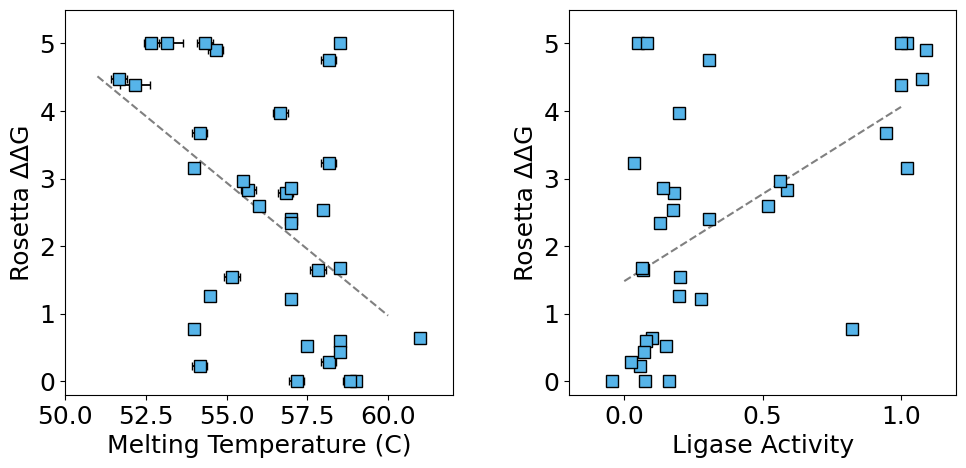

In [64]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11.5,5),)


ax1.errorbar(tm_avg,rosetta_tm_lig_var,xerr=tm_std,fmt='s',
            elinewidth=1.3,ms=8,capsize=3,capthick=1,c='k',mec='k',mfc='#56b4e9')

ax1.set_xlim(50,62)
ax1.set_ylim(-0.2,5.5)

ax1.set_xlabel('Melting Temperature (C)',fontsize=18)
ax1.set_ylabel('Rosetta \u0394\u0394G',fontsize=18)

p,n=np.polyfit(tm_avg,rosetta_tm_lig_var, 1)
print(p,n)

ax1.plot([51,60],[p*51+n,p*60+n],'--',c='gray')

ax2.errorbar(data_excel_file['Ratio UbcH7 lost'].to_numpy(),rosetta_tm_lig_var,fmt='s',
            elinewidth=1.3,ms=8,capsize=3,capthick=1,c='k',mec='k',mfc='#56b4e9')

ax2.set_xlim(-0.2,1.2)
ax2.set_ylim(-0.2,5.5)

ax2.set_xlabel('Ligase Activity',fontsize=18)
ax2.set_ylabel('Rosetta \u0394\u0394G',fontsize=18)

plt.subplots_adjust(wspace=0.3,
                    hspace=0.4)

p,n=np.polyfit(data_excel_file['Ratio UbcH7 lost'].to_numpy(),rosetta_tm_lig_var, 1)
print(p,n)

ax2.plot([0,1],[p*0+n,p*1+n],'--',c='gray')


print('1',sp.stats.spearmanr(tm_avg,rosetta_tm_lig_var)[0])
print('1',sp.stats.spearmanr(data_excel_file['Ratio UbcH7 lost'].to_numpy(),rosetta_tm_lig_var)[0])

plt.savefig('./figures/PRKN_TM_rosetta_correlations.pdf')

### Hyperactivity data

In [65]:
data_excel_file=pd.read_excel('./SupplementalFile1.xlsx',sheet_name=3)

In [66]:
stdev=[]
for prot in data_excel_file['hyperactive variants']:
    if prot== 'WT':
        stdev.append(0.)
    else:
        stdev.append(PARKIN_scores_err[int(prot[1:-1])-1,alphabetAA_L_D[prot[-1]]-1])

-0.10034541185506908 1.049059469245454
1 -0.19248120300751878


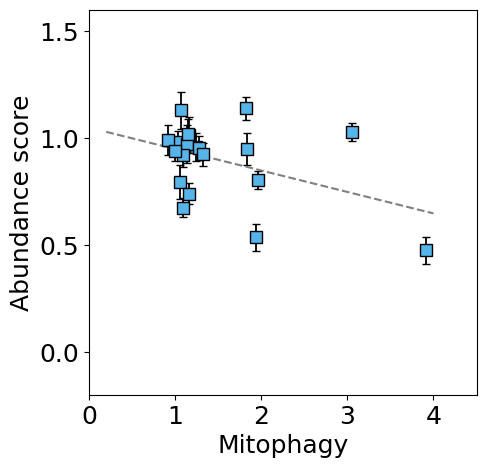

In [67]:
fig, ax1 = plt.subplots(1,1,figsize=(5,5))

ax1.errorbar(data_excel_file['normalized hyperactivity to WT and to GFP levels from Yi 2019'].to_numpy(),data_excel_file['vamp-seq scores'].to_numpy(),yerr=data_excel_file['vamp-seq stdev'].to_numpy(),fmt='s',
            elinewidth=1.3,ms=8,capsize=3,capthick=1,c='k',mec='k',mfc='#56b4e9')

ax1.set_xlim(0,4.5)
ax1.set_ylim(-0.2,1.6)

ax1.set_xlabel('Mitophagy',fontsize=18)
ax1.set_ylabel('Abundance score',fontsize=18)

p,n=np.polyfit(data_excel_file['normalized hyperactivity to WT and to GFP levels from Yi 2019'].to_numpy(),data_excel_file['vamp-seq scores'].to_numpy(), 1)
print(p,n)

ax1.plot([0.2,4],[p*0.2+n,p*4+n],'--',c='gray')

print('1',sp.stats.spearmanr(data_excel_file['normalized hyperactivity to WT and to GFP levels from Yi 2019'].to_numpy(),data_excel_file['vamp-seq scores'].to_numpy())[0])

#plt.savefig('./figures/PRKN_hyperactivity_mitophagy_correlations.pdf')

### Correlations with experiments:


spearman's r: 0.6037841153531421
boostraping confidence interval: ConfidenceInterval(low=0.5893480736353133, high=0.617684398226229)


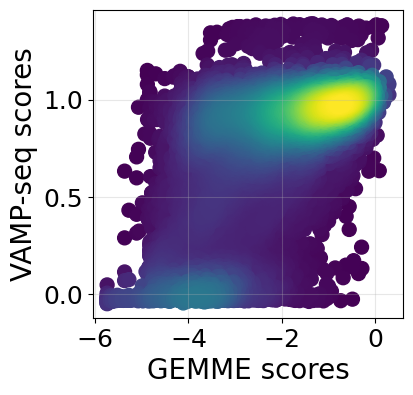

In [68]:
correlation_plot(GEMME_PARKIN_scores.flatten(),PARKIN_scores.flatten(),'GEMME scores', 'VAMP-seq scores')

#plt.savefig('./figures/PARKING_correlation_GEMME_full_VAMPseq.pdf',dpi=300, facecolor='w')

spearman's r: 0.6479969188462227
boostraping confidence interval: ConfidenceInterval(low=0.580891351787217, high=0.7034703568815448)


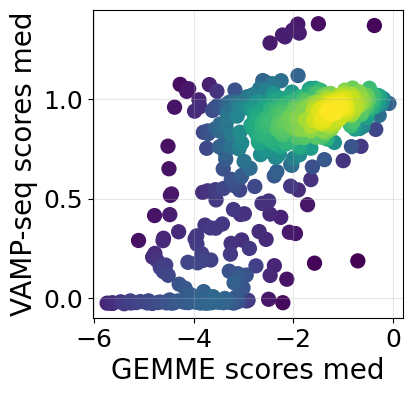

In [69]:
correlation_plot(GEMME_PARKIN_scores_med.flatten(),PARKIN_scores_med.flatten(),'GEMME scores med', 'VAMP-seq scores med')

#plt.savefig('./figures/PARKING_correlation_GEMME_full_VAMPseq_med.pdf',dpi=300, facecolor='w')

spearman's r: -0.4667445201509794
boostraping confidence interval: ConfidenceInterval(low=-0.4853232700703882, high=-0.4487525666081399)


(5.5, -0.5)

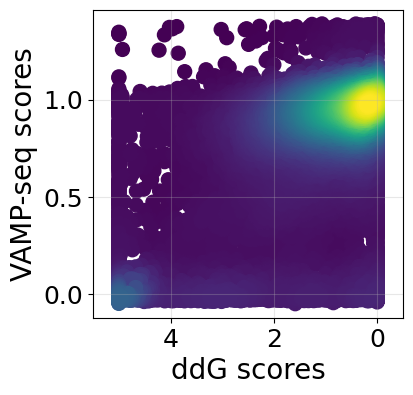

In [70]:
correlation_plot(normalized_rosetta_PARKIN_AF.flatten(),PARKIN_scores.flatten(),'ddG scores', 'VAMP-seq scores')
plt.xlim(5.5,-0.5)
#plt.savefig('./figures/PARKIN_correlation_rosetta_full_VAMPseq.pdf',dpi=300, facecolor='w')

spearman's r: -0.5579597973922845
boostraping confidence interval: ConfidenceInterval(low=-0.6220077421898541, high=-0.48509314018388544)


(5.5, -0.5)

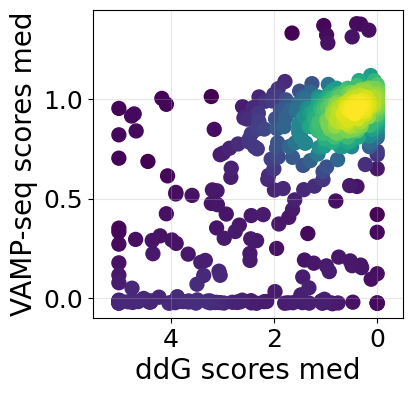

In [71]:
correlation_plot(normalized_rosetta_PARKIN_AF_avg.flatten(),PARKIN_scores_med.flatten(),'ddG scores med', 'VAMP-seq scores med')
plt.xlim(5.5,-0.5)
#plt.savefig('./figures/PARKIN_correlation_rosetta_full_VAMPseq_med.pdf',dpi=300, facecolor='w')

### exposure measures vs abundance

-0.1576185793946539 4.071155241170019
SpearmanrResult(correlation=-0.657470866532676, pvalue=6.823732454250481e-59)


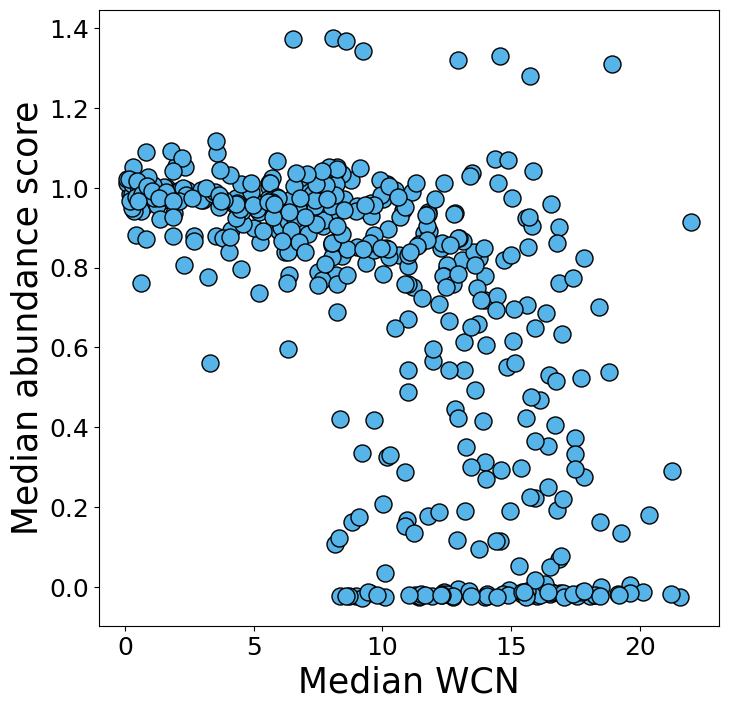

In [72]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.scatter(PARKIN_wcn,PARKIN_scores_med.flatten(),s=150,edgecolor='k',c='#56b4e9')

p,n=np.polyfit(PARKIN_wcn_tile,PARKIN_degron_tiles[:,1].flatten(), 1)
print(p,n)

#ax.plot([0,16],[p*0+n,p*16+n],'--',c='gray')
ax.set_xlabel('Median WCN',fontsize=25)
ax.set_ylabel('Median abundance score',fontsize=25)


print(sp.stats.spearmanr(PARKIN_wcn,PARKIN_scores_med.flatten()))

plt.savefig('./figures/PARKIN_abundance_med_wcn_medians_tile.pdf')

SpearmanrResult(correlation=0.7139527451002037, pvalue=1.1231333049960603e-73)


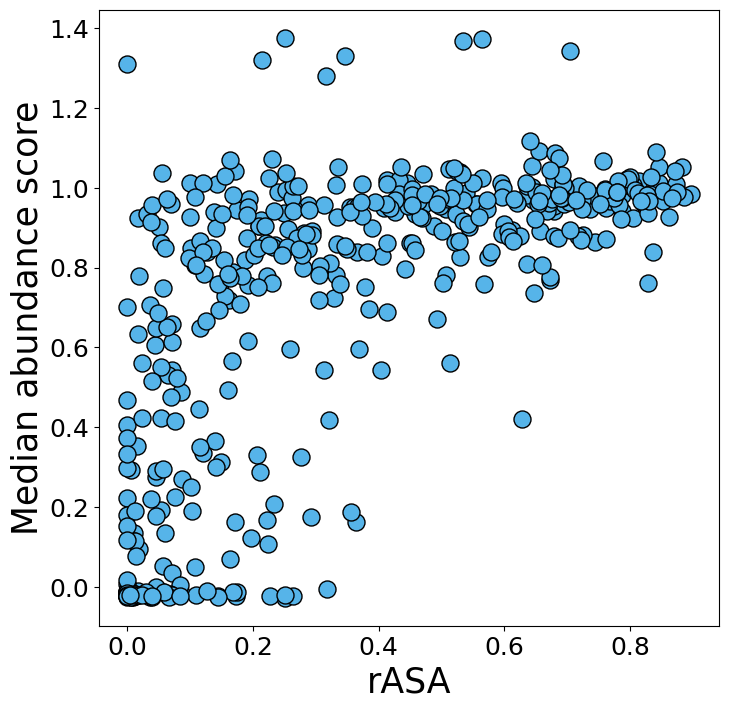

In [73]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.scatter(PARKIN_rASA,PARKIN_scores_med.flatten(),s=150,edgecolor='k',c='#56b4e9')

#ax.plot([0,16],[p*0+n,p*16+n],'--',c='gray')
ax.set_xlabel('rASA',fontsize=25)
ax.set_ylabel('Median abundance score',fontsize=25)

print(sp.stats.spearmanr(PARKIN_rASA,PARKIN_scores_med.flatten()))

plt.savefig('./figures/PARKIN_abundance_med_rASA_medians_tile.pdf')

### Degron

#### experimental measure

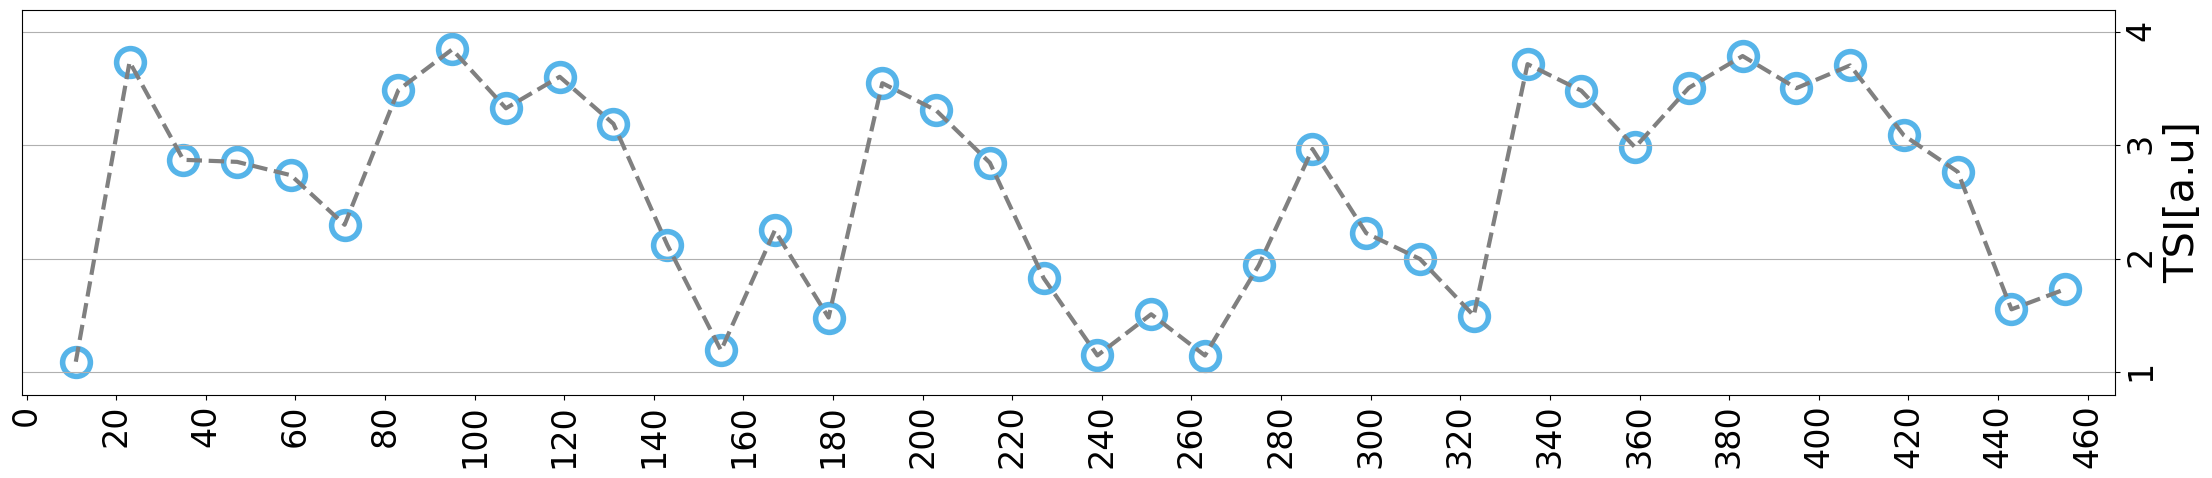

In [74]:
fig,ax =plt.subplots(1,1,figsize=(27,5))
ax.plot(PARKIN_degron_tiles[:,0].flatten(),PARKIN_degron_tiles[:,1].flatten(),ls='--',color='grey',lw=3)
idx= np.isfinite(PARKIN_degron_tiles[:,1].flatten())
ax.scatter(PARKIN_degron_tiles[:,0].flatten()[idx],PARKIN_degron_tiles[:,1].flatten()[idx],marker='o',c='white',lw=2,s=400,facecolor='white',edgecolor='#56b4e9', linewidth=4)
ax.set_ylabel('TSI[a.u]',fontsize=30)
ax.set_xticks(np.arange(5, len(PARKIN_WT_sequence), 12))
ax.set_ylim(0.8,4.2)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ax.set_xticks(np.arange(0, len(PARKIN_WT_sequence),20))
ax.tick_params(axis='x',rotation=90)
ax.set_xticklabels(np.arange(0, len(PARKIN_WT_sequence), 20),fontsize=24)
ax.set_xlim(-1,466)

ax.set_yticks(np.arange(1, 4.5, 1))
ax.tick_params(axis='y',rotation=90)
ax.set_yticklabels(np.arange(1, 5, 1),fontsize=24)
ax.grid(axis='y',which='major')

#plt.savefig('./figures/PRKN_degron_exp_unique.pdf')

0.9731882980436635 -0.016719782739070044
SpearmanrResult(correlation=0.8596965005684859, pvalue=3.9797161218931365e-05)


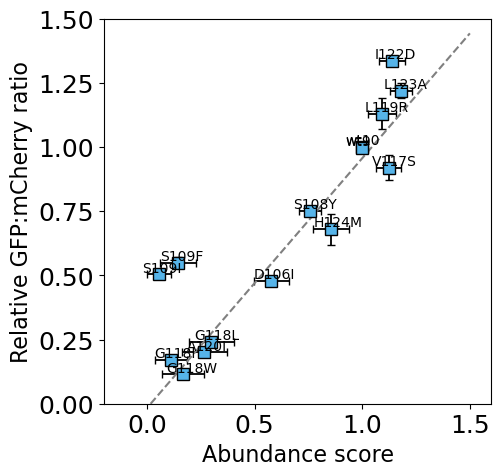

In [75]:
fig, ax = plt.subplots(figsize=(5,5))

ax.errorbar(PARKIN_degron_tile_9_10_single['vamp'],PARKIN_degron_tile_9_10_single['score'],xerr=PARKIN_degron_tile_9_10_single['vamp_error'], yerr=PARKIN_degron_tile_9_10_single['error'],fmt='s',
            elinewidth=1.3,ms=8,capsize=3,capthick=1,c='k',mec='k',mfc='#56b4e9')

label_single=PARKIN_degron_tile_9_10_single['mutation'].to_list()
for i, label in enumerate(label_single):
    ax.annotate(label, (PARKIN_degron_tile_9_10_single['vamp'][i]-0.08, PARKIN_degron_tile_9_10_single['score'][i]+0.01))
    
p,n=np.polyfit(PARKIN_degron_tile_9_10_single['score'],PARKIN_degron_tile_9_10_single['vamp'], 1)
print(p,n)

ax.plot([-0.05,1.5],[p*-0.05+n,p*1.5+n],'--',c='gray')
ax.set_xlim(-0.2,1.6)
ax.set_ylim(0,1.5)

ax.set_ylabel('Relative GFP:mCherry ratio',fontsize=16)
ax.set_xlabel('Abundance score',fontsize=16)

print(sp.stats.spearmanr(PARKIN_degron_tile_9_10_single['score'],PARKIN_degron_tile_9_10_single['vamp']))

#plt.savefig('./figures/PRKN_tile_single_replicas.pdf')

#### QCDpred

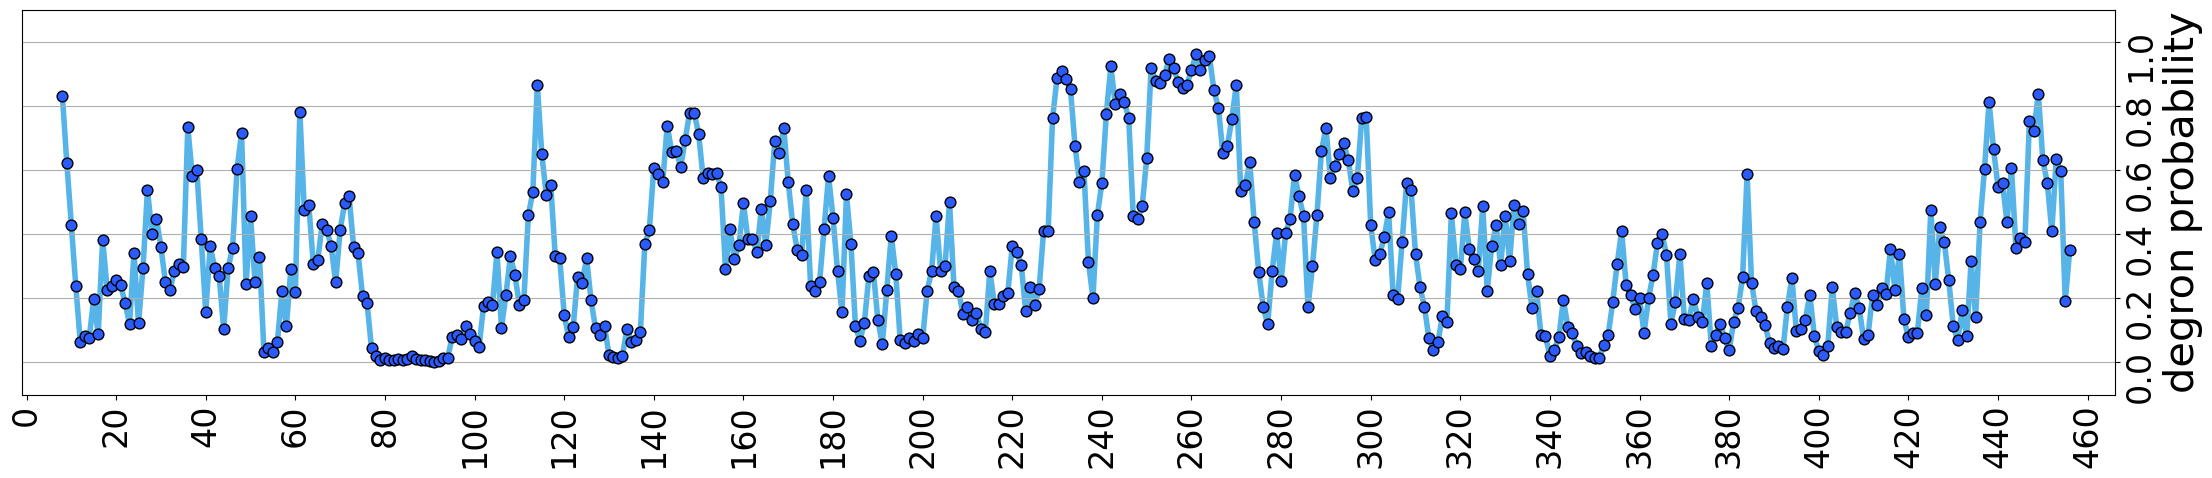

In [76]:
fig,ax =plt.subplots(1,1,figsize=(27,5))
ax.plot(np.arange(0,len(PARKIN_WT_sequence),1),PARKIN_pred_degron.flatten(),ls='-',color='#56B4E9',lw=4,zorder=1)
ax.scatter(np.arange(0,len(PARKIN_WT_sequence),1),PARKIN_pred_degron.flatten(),marker='o',lw=1,s=60,facecolor='#2B5BFF',edgecolor='k',zorder=10)
ax.set_ylabel('degron probability',fontsize=30)
ax.set_xticks(np.arange(5, len(PARKIN_WT_sequence), 12))

ax.set_xlim(-1,466)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


ax.set_xticks(np.arange(0, len(PARKIN_WT_sequence),20))
ax.tick_params(axis='x',rotation=90)
ax.set_xticklabels(np.arange(0, len(PARKIN_WT_sequence), 20),fontsize=24)

#ax.set_yticks(np.arange(0,1,0.2))
ax.tick_params(axis='y',rotation=90)
ax.set_yticklabels([-0.2,0.,.2,.4,.6,.8,1.],fontsize=24)
ax.set_ylim(-0.1,1.1)
ax.grid(axis='y',which='major')

#plt.savefig('./figures/PRKN_degron_pred_unique.pdf')

(-0.5, 37.5)

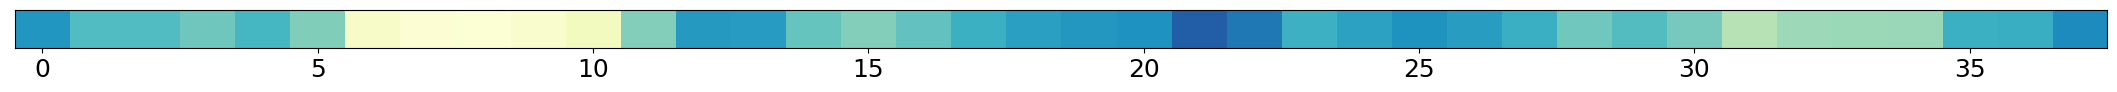

In [77]:
fig, (ax1) = plt.subplots(1,1,figsize=(27,0.5))

ax1.imshow(np.array(PARKIN_wcn_tile).reshape(1,-1),aspect= 'auto',cmap='YlGnBu',vmin=0,vmax=21,interpolation='nearest')
ax1.set_yticks([])
ax1.set_xlim(-0.5,len(PARKIN_wcn_tile)+.5-1)

#plt.savefig('./figures/PARKIN_heamap_WCN_tile.pdf',dpi=300, facecolor='w')

In [78]:
pd.DataFrame({'tile_number':np.arange(1,39,1),'wcn_median_tile':PARKIN_wcn_tile,'tile TSI':PARKIN_degron_tiles[:,1].flatten()}).to_csv('../Outputs/PRKN_degron_wcn_median.csv')

-0.1576185793946539 4.071155241170019
SpearmanrResult(correlation=-0.7618318116124785, pvalue=2.7686016983370185e-08)


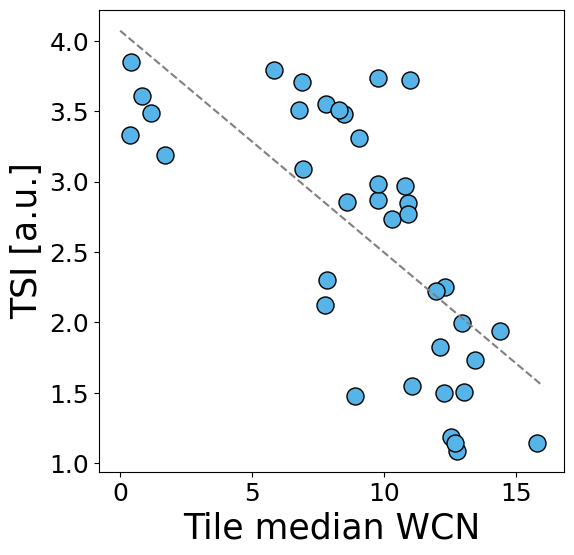

In [79]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
ax.scatter(PARKIN_wcn_tile,PARKIN_degron_tiles[:,1].flatten(),s=150,edgecolor='k',c='#56b4e9')

p,n=np.polyfit(PARKIN_wcn_tile,PARKIN_degron_tiles[:,1].flatten(), 1)
print(p,n)

ax.plot([0,16],[p*0+n,p*16+n],'--',c='gray')
ax.set_xlabel('Tile median WCN',fontsize=25)
ax.set_ylabel('TSI [a.u.]',fontsize=25)


print(sp.stats.spearmanr(PARKIN_degron_tiles[:,1],PARKIN_wcn_tile))

#plt.savefig('./figures/PARKIN_degron_wcn_medians_tile.pdf')

### Functional model

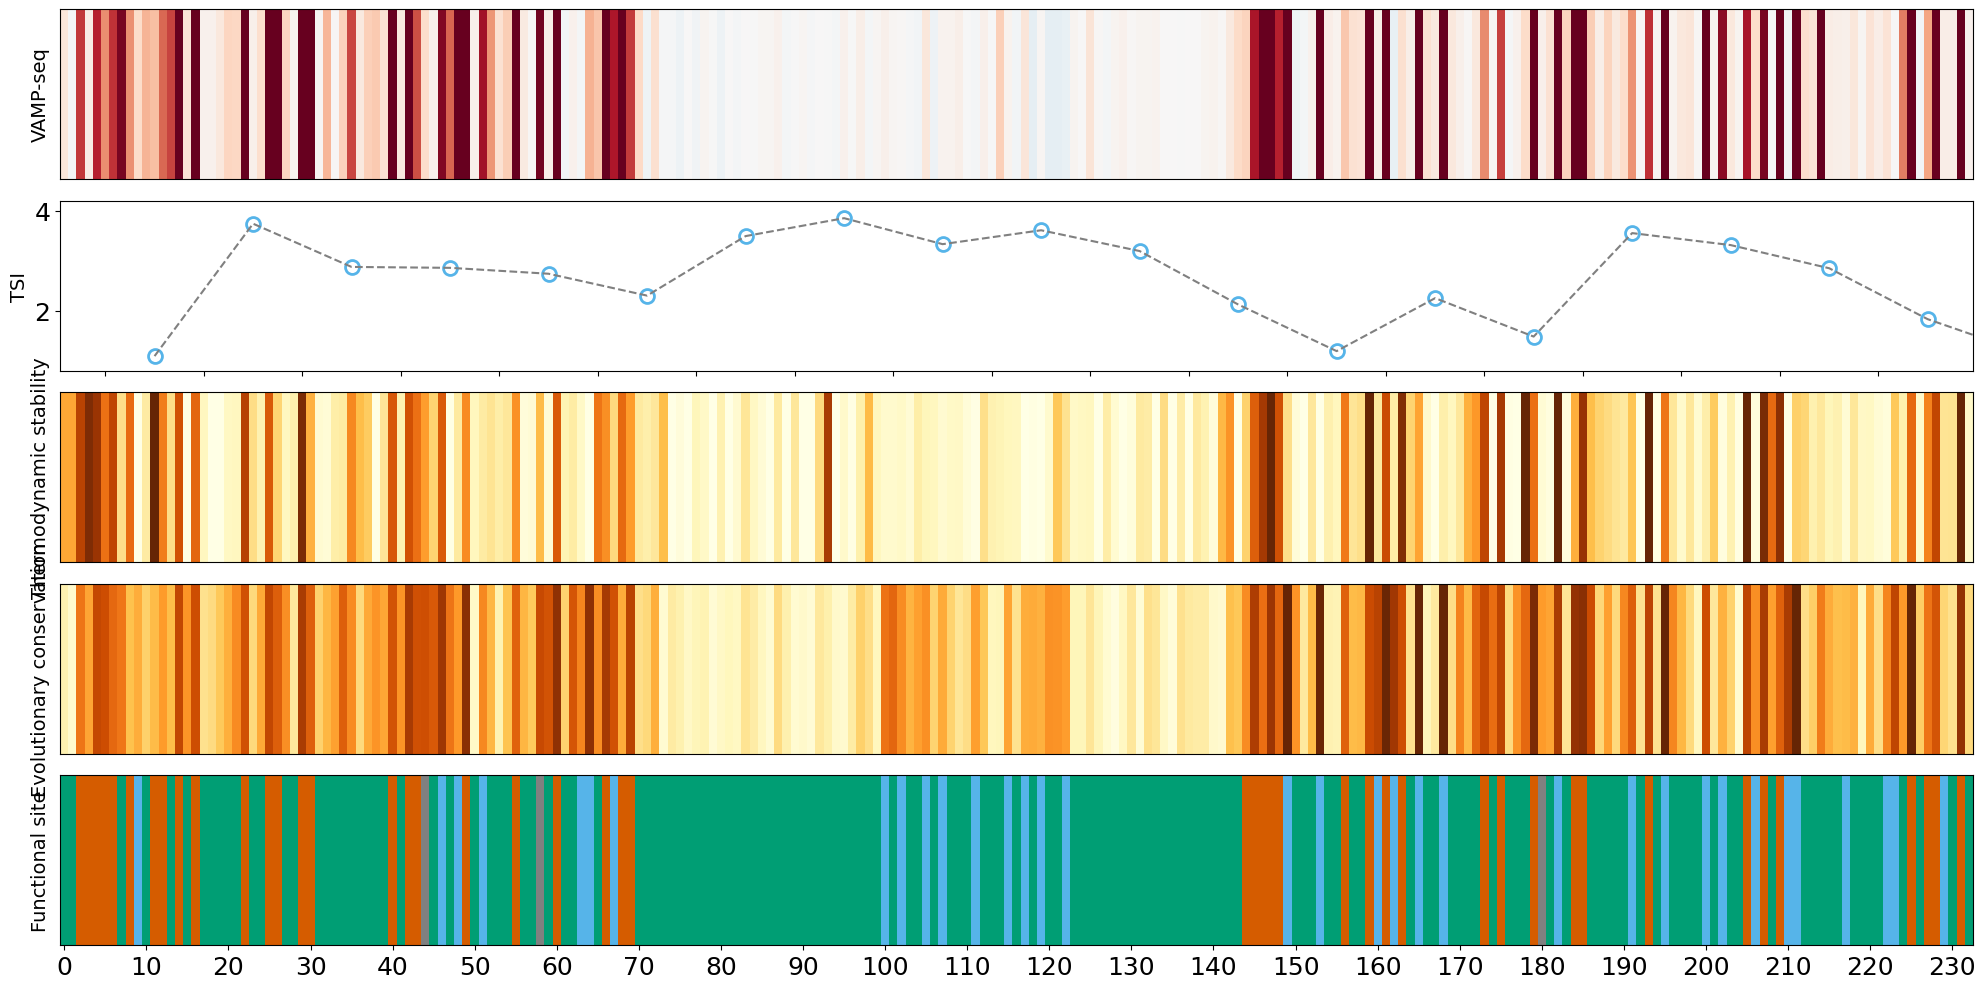

In [80]:
# Comparison with experimental MAVE residue colour classification
fig, ((ax1),(ax2),(ax3),(ax4),(ax5)) = plt.subplots(5,1,figsize=(20,10))

ax1.imshow(PARKIN_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_ylabel('VAMP-seq',fontsize=14)
ax1.set_xticks([])
ax1.set_xlim(-0.5,232+0.5)

ax2.plot(PARKIN_degron_tiles[:,0].flatten(),PARKIN_degron_tiles[:,1].flatten(),ls='--',color='grey')
idx= np.isfinite(PARKIN_degron_tiles[:,1].flatten())
ax2.scatter(PARKIN_degron_tiles[:,0].flatten()[idx],PARKIN_degron_tiles[:,1].flatten()[idx],marker='o',c='white',lw=2,s=100,facecolor='white',edgecolor='#56b4e9')

ax2.set_ylabel('TSI',fontsize=14)
ax2.set_xticklabels([])
ax2.set_xticks(np.arange(5, len(PARKIN_WT_sequence), 12))
ax2.set_ylim(0.8,4.2)
ax2.set_xlim(-0.5,232+0.5)

#ax1.set_xlabel('residue')
ax3.imshow(normalized_rosetta_PARKIN_AF_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=5,interpolation='nearest')
ax3.set_yticks([])
ax3.set_ylabel('Thermodynamic stability',fontsize=14)
ax3.set_xticks([])
ax3.set_xlim(-0.5,232+0.5)

ax4.imshow(GEMME_PARKIN_scores_med.reshape(1,-1),aspect= 'auto',cmap='YlOrBr_r',vmin=-5,vmax=0,interpolation='nearest')
ax4.set_yticks([])
ax4.set_ylabel('Evolutionary conservation',fontsize=14)
ax4.set_xticks([])
ax4.set_xlim(-0.5,232+0.5)

ax5.imshow(FM_prediction_residues.reshape(1,-1),aspect= 'auto', cmap=mpl.colors.ListedColormap(["#009e74", "#56b4e9","#d55c00",'gray','gray','gray']))
ax5.set_yticks([])
ax5.xaxis.set_ticks(np.arange(0, len(PARKIN_WT_sequence), 10))
ax5.set_ylabel('Functional site',fontsize=14)
ax5.set_xlim(-0.5,232+0.5)



plt.tight_layout()
#plt.savefig('./figures/PARKIN_heatmap_res_part1.pdf',dpi=300, facecolor='w')

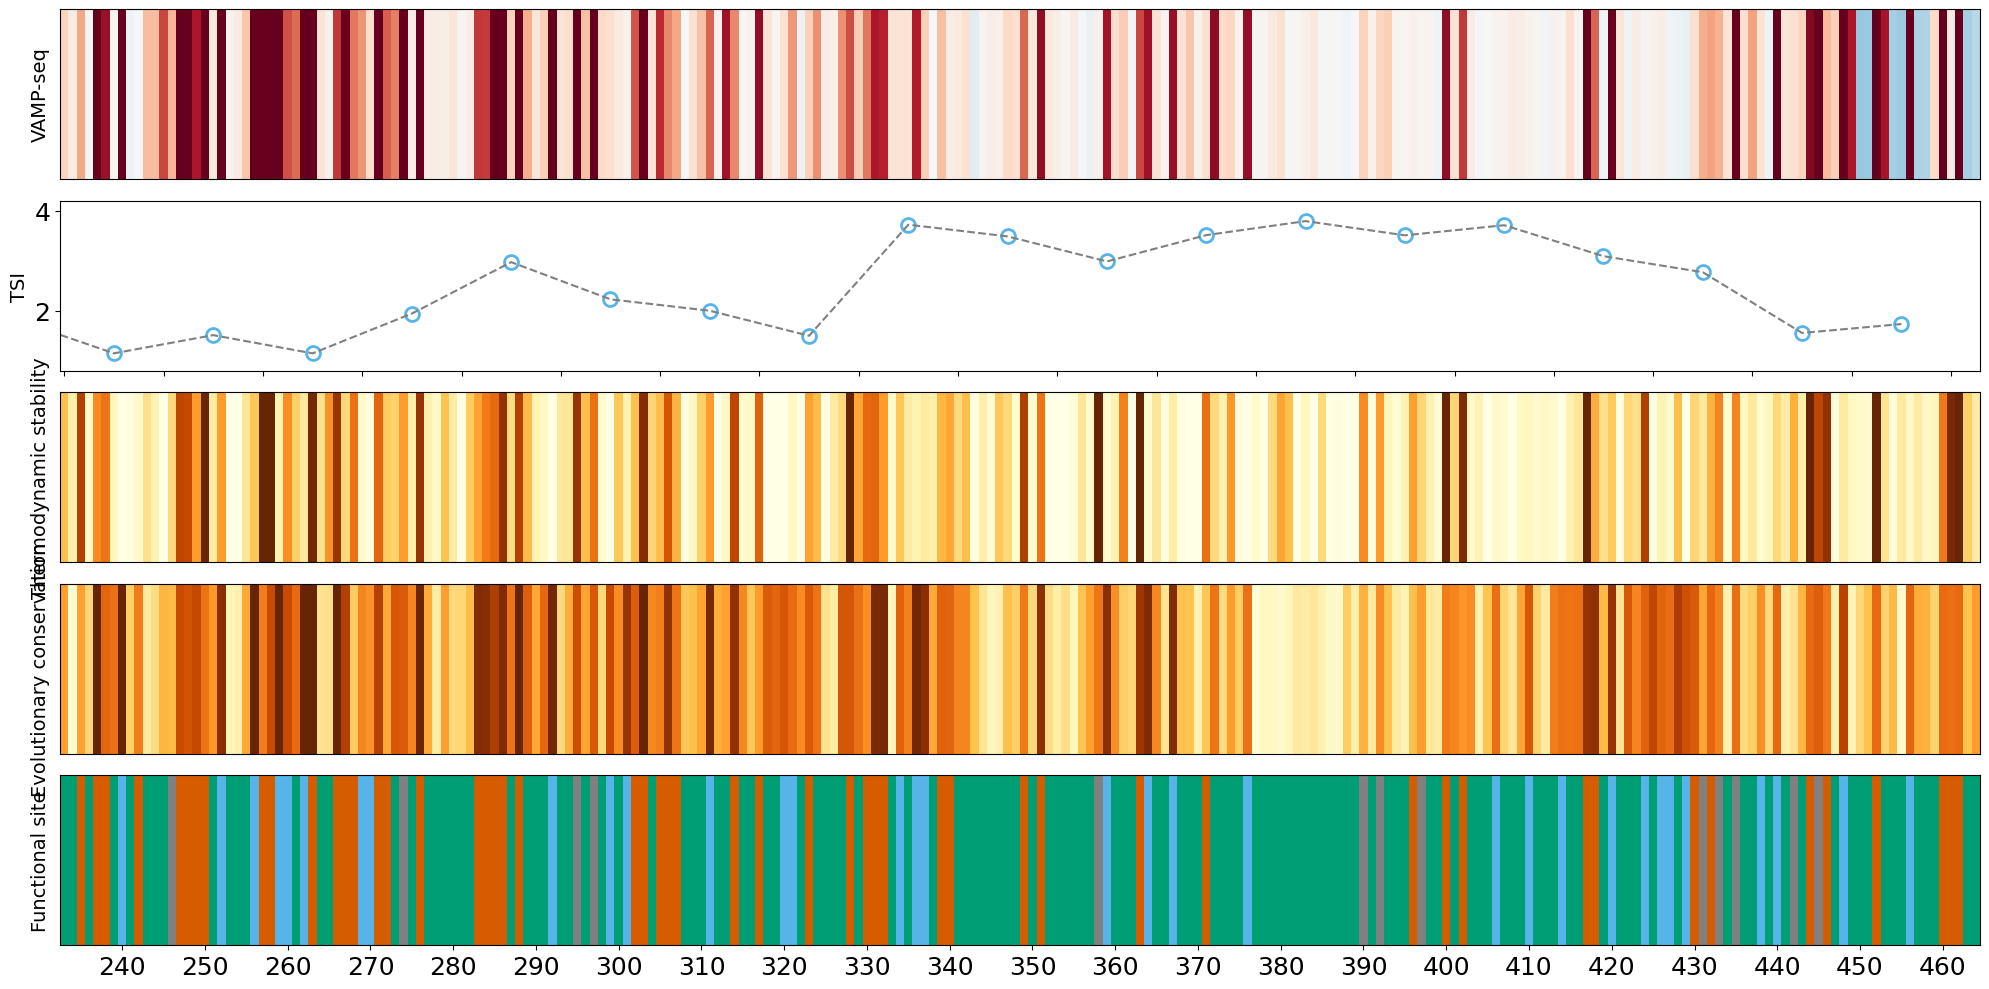

In [81]:
# Comparison with experimental MAVE residue colour classification
fig, ((ax1),(ax2),(ax3),(ax4),(ax5)) = plt.subplots(5,1,figsize=(20,10))

ax1.imshow(PARKIN_scores_med.reshape(1,-1),aspect= 'auto',cmap='RdBu',vmin=0,vmax=2,interpolation='nearest')
ax1.set_yticks([])
ax1.set_ylabel('VAMP-seq',fontsize=14)
ax1.set_xticks([])
ax1.set_xlim(233-0.5,len(PARKIN_WT_sequence)-0.5)

ax2.plot(PARKIN_degron_tiles[:,0].flatten(),PARKIN_degron_tiles[:,1].flatten(),ls='--',color='grey')
idx= np.isfinite(PARKIN_degron_tiles[:,1].flatten())
ax2.scatter(PARKIN_degron_tiles[:,0].flatten()[idx],PARKIN_degron_tiles[:,1].flatten()[idx],marker='o',c='white',lw=2,s=100,facecolor='white',edgecolor='#56b4e9')

ax2.set_ylabel('TSI',fontsize=14)
ax2.set_xticklabels([])
ax2.set_xticks(np.arange(5, len(PARKIN_WT_sequence), 12))
ax2.set_ylim(0.8,4.2)
ax2.set_xlim(233-0.5,len(PARKIN_WT_sequence)-0.5)

#ax1.set_xlabel('residue')
ax3.imshow(normalized_rosetta_PARKIN_AF_avg.reshape(1,-1),aspect= 'auto',cmap='YlOrBr',vmin=0,vmax=5,interpolation='nearest')
ax3.set_yticks([])
ax3.set_ylabel('Thermodynamic stability',fontsize=14)
ax3.set_xticks([])
ax3.set_xlim(233-0.5,len(PARKIN_WT_sequence)-0.5)

ax4.imshow(GEMME_PARKIN_scores_med.reshape(1,-1),aspect= 'auto',cmap='YlOrBr_r',vmin=-5,vmax=0,interpolation='nearest')
ax4.set_yticks([])
ax4.set_ylabel('Evolutionary conservation',fontsize=14)
ax4.set_xticks([])
ax4.set_xlim(233-0.5,len(PARKIN_WT_sequence)-0.5)

ax5.imshow(FM_prediction_residues.reshape(1,-1),aspect= 'auto', cmap=mpl.colors.ListedColormap(["#009e74", "#56b4e9","#d55c00",'gray','gray','gray']))
ax5.set_yticks([])
ax5.xaxis.set_ticks(np.arange(0, len(PARKIN_WT_sequence), 10))
ax5.set_ylabel('Functional site',fontsize=14)
ax5.set_xlim(233-0.5,len(PARKIN_WT_sequence)-0.5)



plt.tight_layout()
#plt.savefig('./figures/PARKIN_heatmap_res_part1.pdf',dpi=300, facecolor='w')

### Clinical variants
#### gnomad frequencies

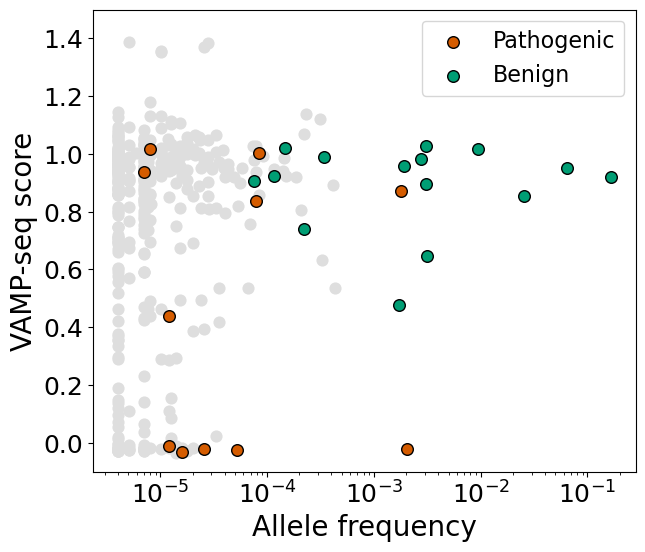

In [82]:
fig,ax=plt.subplots(1,1,figsize=(7,6))

ax.scatter(gnomad_PARKIN_freq_db_matrix,PARKIN_scores,c='#DEDEDE',s=60)

idx = np.isfinite(df_disease[df_disease['disease']=='pathogenic']['freq_gnomad'].to_numpy()) & np.isfinite(df_disease[df_disease['disease']=='pathogenic']['mave'].to_numpy() )
ax.scatter(df_disease['freq_gnomad'][df_disease['disease']=='pathogenic'].to_numpy()[idx],df_disease['mave'][df_disease['disease']=='pathogenic'].to_numpy()[idx],c='#d55c00',s=70,edgecolors='k',label='Pathogenic')

idx = np.isfinite(df_disease[df_disease['disease']=='benign']['freq_gnomad'].to_numpy()) & np.isfinite(df_disease[df_disease['disease']=='benign']['mave'].to_numpy() )
ax.scatter(df_disease[df_disease['disease']=='benign']['freq_gnomad'].to_numpy()[idx],df_disease[df_disease['disease']=='benign']['mave'].to_numpy()[idx],c='#009e74',s=70,edgecolors='k',label='Benign')

ax.set_xscale('log')
ax.set_xlabel('Allele frequency')
ax.set_ylabel('VAMP-seq score')
ax.set_ylim(-0.1,1.5)
ax.legend(fontsize=16)
#plt.savefig('./figures/PARKIN_gnomad_valid_frequency_variants.pdf')

(-0.1, 1.5)

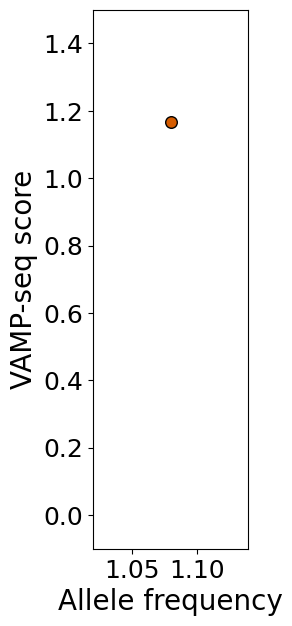

In [83]:
fig,ax=plt.subplots(1,1,figsize=(2,7))
temp=df_disease
temp_array=[]
for i in range(len(temp['freq_gnomad'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='pathogenic':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        if temp.iloc[i,temp.columns.get_loc('freq_gnomad')]==np.inf:
            temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])
            
ax.scatter([1+random()/10 for i in range(0,len(temp_array))],temp_array,c='#d55c00',s=70,edgecolors='k')


temp_array=[]
for i in range(len(temp['freq_gnomad'])):
    if temp.iloc[i,temp.columns.get_loc('disease')]=='benign':
        #print(temp.iloc[i,temp.columns.get_loc('freq_gnomad')])
        if temp.iloc[i,temp.columns.get_loc('freq_gnomad')]==np.inf:
            temp_array.append(temp.iloc[i,temp.columns.get_loc('mave')])
            

ax.scatter([1+random()/10 for i in range(0,len(temp_array))],temp_array,c='#009e74',s=70,edgecolor='k')


ax.set_xlabel('Allele frequency')
ax.set_ylabel('VAMP-seq score')
ax.set_ylim(-0.1,1.5)
#plt.savefig('./figures/PARKIN_gnomad_null_frequency_variants.pdf')

#### coevo vs vamp_seq with clinvar


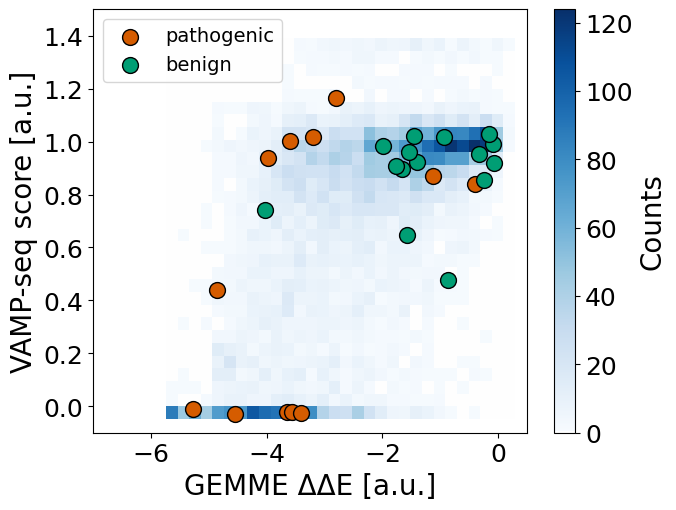

In [84]:
fig,ax=plt.subplots(1,1,figsize=(7,5.5))

y=[]; x=[]

y_size=[1.5,-0.1]
x_size=[-7,0.5]

# Create the vectors with the common dataset between the two experiment
# It remove a variant data if one of the two MAVE array contain a NA as score for that mutation.
for i in range(GEMME_PARKIN_scores.shape[0]):
    for j in range(GEMME_PARKIN_scores.shape[1]):
        if np.isnan(GEMME_PARKIN_scores[i,j]) or np.isnan(PARKIN_scores[i,j]):
            pass
        else:
            x.append(float(GEMME_PARKIN_scores[i,j]))
            y.append(float(PARKIN_scores[i,j]))

# Common variant assays
y=np.array(y)
x=np.array(x)

#Plot the 2d histogram
ax.set_ylabel("VAMP-seq score [a.u.]")
ax.set_xlabel("GEMME \u0394\u0394E [a.u.]")
mappable = ax.hist2d(x,y,bins=[30,30],cmap =newcmp2)# norm=mpl.colors.LogNorm()
cbar = fig.colorbar(mappable[3],label="Counts")

#plt.legend(loc='upper left',fontsize=12)
ax.set_xlim(x_size[0],x_size[1])
ax.set_ylim(y_size[1],y_size[0])

ax.scatter(df_disease[df_disease['disease']=='pathogenic']['gemme'].to_numpy(),df_disease[df_disease['disease']=='pathogenic']['mave'].to_numpy(),c='#d55c00',s=130,edgecolors='k',label='pathogenic')
ax.scatter(df_disease[df_disease['disease']=='benign']['gemme'].to_numpy(),df_disease[df_disease['disease']=='benign']['mave'].to_numpy(),c='#009e74',s=130,edgecolors='k',label='benign')


ax.legend(loc='upper left')
#plt.savefig('./figures/PARKIN_2d_vamp_gemme_clinvar.pdf')

#### ROC - AUC pathogenic variants


In [85]:
class_clin=[]
class_vamp=[]
#load list with class from cloinvar e mave
for k in range(len(df_disease['mutation'])):
    if np.isnan(df_disease['mave'][k])!=True:
        if df_disease['disease'][k]=='benign':
            class_clin.append(0)
        elif df_disease['disease'][k]=='pathogenic':
            class_clin.append(1)

        else:
            pass
        class_vamp.append(1-df_disease['mave'][k])

vamp_fpr, vamp_tpr, _ = roc_curve(class_clin, class_vamp)
roc_auc_vamp = auc(vamp_fpr, vamp_tpr)

print(vamp_tpr,roc_auc_vamp)

[0.         0.08333333 0.5        0.5        0.58333333 0.58333333
 0.66666667 0.66666667 0.75       0.75       0.83333333 0.83333333
 0.91666667 0.91666667 1.        ] 0.6944444444444445


In [86]:
class_clin=[]
class_ddgs=[]
#load list with class from cloinvar e mave
for k in range(len(df_disease['mutation'])):
    if np.isnan(df_disease['ddg_AF'][k])!=True:
        if df_disease['disease'][k]=='benign':
            class_clin.append(0)
        elif df_disease['disease'][k]=='pathogenic':
            class_clin.append(1)

        else:
            pass
        class_ddgs.append(df_disease['ddg_AF'][k])

ddg_fpr, ddg_tpr, _ = roc_curve(class_clin, class_ddgs)
roc_auc_ddg = auc(ddg_fpr,ddg_tpr)

print(ddg_tpr,roc_auc_ddg)

[0.         0.07142857 0.28571429 0.28571429 0.64285714 0.64285714
 0.71428571 0.71428571 0.78571429 0.78571429 0.85714286 0.85714286
 0.92857143 0.92857143 1.        ] 0.7904761904761906


In [87]:
class_clin=[]
class_gemme=[]
#load list with class from cloinvar e mave
for k in range(len(df_disease['mutation'])):
    if np.isnan(df_disease['gemme'][k])!=True:
        if df_disease['disease'][k]=='benign':
            class_clin.append(0)
        elif df_disease['disease'][k]=='pathogenic':
            class_clin.append(1)

        else:
            pass
        class_gemme.append(np.min(df_disease['gemme'].to_numpy()) - df_disease['gemme'][k])

gemme_fpr, gemme_tpr, _ = roc_curve(class_clin, class_gemme)
roc_auc_gemme = auc(gemme_fpr, gemme_tpr)

print(gemme_tpr,roc_auc_gemme)

[0.         0.07142857 0.21428571 0.21428571 0.71428571 0.71428571
 0.78571429 0.78571429 1.         1.        ] 0.7857142857142858


In [88]:
class_clin=[]
class_EVE=[]
#load list with class from cloinvar e mave
for k in range(len(df_disease['mutation'])):
    if np.isnan(df_disease['EVE'][k])!=True:
        if df_disease['disease'][k]=='benign':
            class_clin.append(0)
        elif df_disease['disease'][k]=='pathogenic':
            class_clin.append(1)

        else:
            pass
        class_EVE.append(df_disease['EVE'][k])
EVE_fpr, EVE_tpr, _ = roc_curve(class_clin, class_EVE)
roc_auc_EVE = auc(EVE_fpr, EVE_tpr)

print(EVE_tpr,roc_auc_EVE)

[0.         0.08333333 0.75       0.75       0.83333333 0.83333333
 0.91666667 0.91666667 1.         1.        ] 0.888888888888889


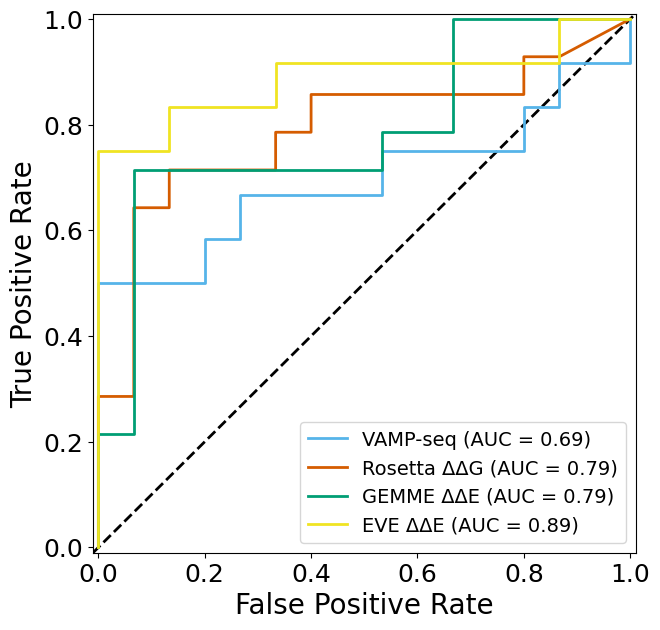

In [89]:
fig,ax=plt.subplots(1,1,figsize=(7,7))
lw=2
ax.plot(
    vamp_fpr,
    vamp_tpr,
    color='#56b4e9',
    lw=lw,
    label="VAMP-seq (AUC = %0.2f)" % (roc_auc_vamp),
    zorder=1
)
ax.plot(
    ddg_fpr,
    ddg_tpr,
    color='#d55c00',
    lw=lw,
    label="Rosetta \u0394\u0394G (AUC = %0.2f)" % (roc_auc_ddg),
    zorder=1
)

ax.plot(
    gemme_fpr,
    gemme_tpr,
    color='#009e74',
    lw=lw,
    label="GEMME \u0394\u0394E (AUC = %0.2f)" % (roc_auc_gemme),
    zorder=1
)

ax.plot(
    EVE_fpr,
    EVE_tpr,
    color='#f0e422',
    lw=lw,
    label="EVE \u0394\u0394E (AUC = %0.2f)" % (roc_auc_EVE),
    zorder=1
)


ax.legend()
ax.plot([-0.01, 1.05], [-0.01, 1.05], color="k", lw=lw, linestyle="--",zorder=-2)
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
        
plt.savefig('./figures/ROC_pathogenic_variants_comparison.pdf',tight_layout=True)

**WARNING The next cell require ptitprince to be run, please install it before executing**

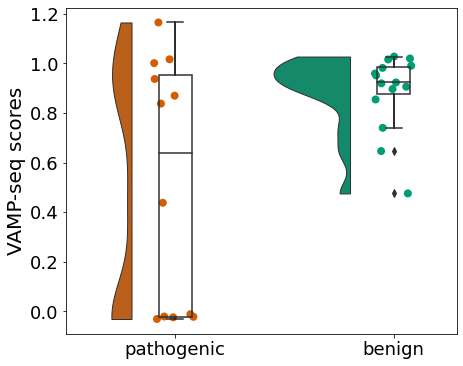

In [ ]:
#same thing with a single command: now x **must** be the categorical value
dx = "disease"; dy = "mave"; ort = "v"; pal = "Set2"; sigma = .3
f, ax = plt.subplots(figsize=(7., 6))

ax1=pt.RainCloud(x = dx, y = dy, data = df_disease, palette = ['#d55c00','#009e74'],
      bw = sigma,width_viol = .7, ax = ax, orient = ort,point_size=8,edgecolor='k')
ax1.set_ylabel('VAMP-seq scores')
ax1.set_xlabel('')
#ax1.plot([-1,3],[PARKIN_syn_scores_med-PARKIN_syn_scores_stdev,PARKIN_syn_scores_med-PARKIN_syn_scores_stdev],c='gray',ls='--',zorder=-1,label='thresholds')

#ax1.legend()

plt.savefig('./figures/PARKIN_pathogenic_benign_raincloud.pdf',tight_layout=True)